## Setup, Loading Data and CDFs

In [3]:
DATA_NAME = 'approx1e5-pastis-fourier-red' # Dataset Format: size-name-transform-channel

In [4]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = False
CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\pastis\\fourier\\approx1e5\\red'

In [5]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [6]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif path_dict['transform'] == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::1000] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 31800,
 3: 22260,
 4: 44520,
 5: 41340,
 6: 50880,
 7: 54060,
 8: 66780,
 9: 63600,
 10: 85860,
 11: 104940,
 12: 111300,
 13: 136740,
 14: 162180,
 15: 187620,
 16: 203520,
 17: 257580,
 18: 289380,
 19: 337080,
 20: 381600,
 21: 470640,
 22: 540600,
 23: 610560,
 24: 712320,
 25: 855420,
 26: 973080,
 27: 1154340,
 28: 1316520,
 29: 1376940,
 30: 960360,
 31: 674160,
 32: 419760,
 33: 162180}

c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2


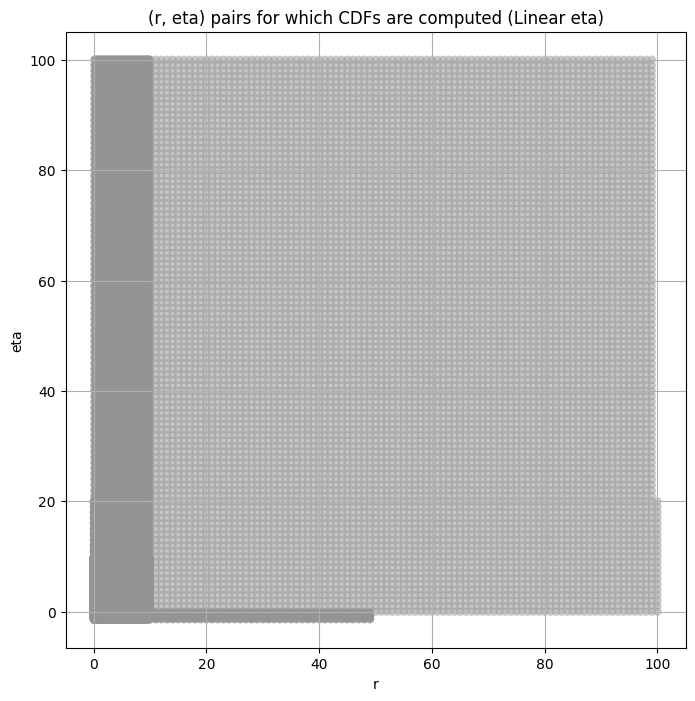

(r,eta),cdf     r  eta  \
0  ((0.02, -1.4), <scipy.interpolate._fitpack2.In...  0.02 -1.4   
1  ((0.02, -1.3), <scipy.interpolate._fitpack2.In...  0.02 -1.3   
2  ((0.02, -1.2), <scipy.interpolate._fitpack2.In...  0.02 -1.2   
3  ((0.02, -1.1), <scipy.interpolate._fitpack2.In...  0.02 -1.1   
4  ((0.02, -1.0), <scipy.interpolate._fitpack2.In...  0.02 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  9.618487e+69   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.821735e+74   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.455488e+78   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.406735e+81   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  5.331443e+83   

       kurtosis  
0  1.391529e+25  
1  8.172634e+21  
2  4.131785e+19  
3  6.947275e+17  
4  2.562075e+16

In [7]:
#warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [05:35<00:00, 297.77it/s]


Band 5


100%|██████████| 100000/100000 [03:58<00:00, 419.78it/s]


Band 8


100%|██████████| 100000/100000 [03:04<00:00, 543.36it/s]


Band 11


100%|██████████| 100000/100000 [03:12<00:00, 519.42it/s]


Band 14


100%|██████████| 100000/100000 [03:22<00:00, 494.84it/s]


Band 17


100%|██████████| 100000/100000 [03:34<00:00, 466.41it/s]


Band 20


100%|██████████| 100000/100000 [03:33<00:00, 467.49it/s]


Band 23


100%|██████████| 100000/100000 [03:32<00:00, 469.62it/s]


Band 26


100%|██████████| 100000/100000 [03:26<00:00, 484.26it/s]


Band 29


100%|██████████| 100000/100000 [03:35<00:00, 463.01it/s]


Band 32


100%|██████████| 100000/100000 [03:29<00:00, 476.41it/s]


obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
band                                                                       
2     157269.880000  149264.110000  165654.390000   2.019593    1.471349   
5      83422.350000   79257.164000   87787.930000   1.903983    1.275784   
8      45610.926000   43328.332000   47969.348000   1.937604    1.312301   
11     25793.922000   24441.889000   27232.033000   2.370253    1.365877   
14     14051.502000   13346.595000   14808.067000   2.089291    1.275146   
17      7919.142600    7515.967300    8348.544000   2.151878    1.293355   
20      4052.697300    3844.855700    4287.259000   2.416864    1.276760   
23      1979.636500    1878.425500    2088.579000   2.248149    1.370794   
26       868.004900     815.872400     934.296900   4.653831    1.694718   
29       329.394470     302.999200     371.574920  13.155254    2.838861   
32        44.476166      42.376705      46.640842   1.459712    1.005672   

      kurt_upper  total_samples  
band                             
2       2.704436        31800.0  
5       2.832162        41340.0  
8       2.837549        66780.0  
11      4.514517       104940.0  
14      4.009901       162180.0  
17      4.513294       257580.0  
20      9.097979       381600.0  
23      4.596758       610560.0  
26     18.998148       973080.0  
29     66.098460      1376940.0  
32      2.262223       419760.0

## Initial Grid Search and Hypothesis Test Plots

####
Band  2


100%|██████████| 55966/55966 [06:13<00:00, 149.98it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 31800, Without approximation : 31800.0


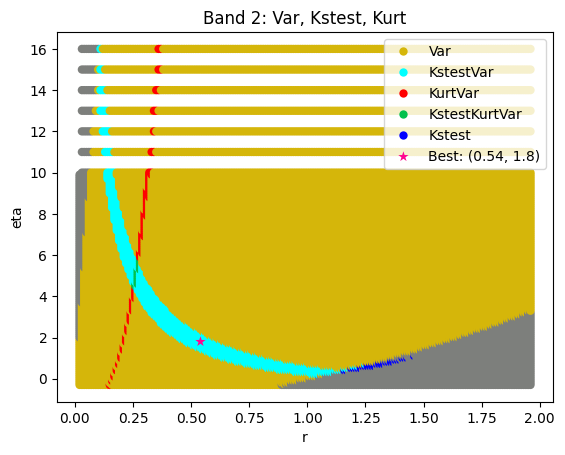

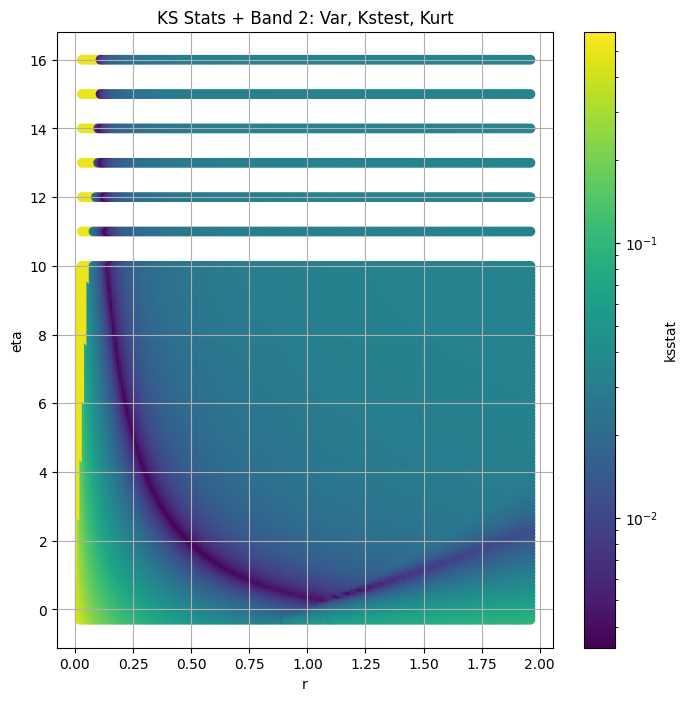

####
Band  5


100%|██████████| 55966/55966 [07:27<00:00, 125.07it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 41340, Without approximation : 41340.0


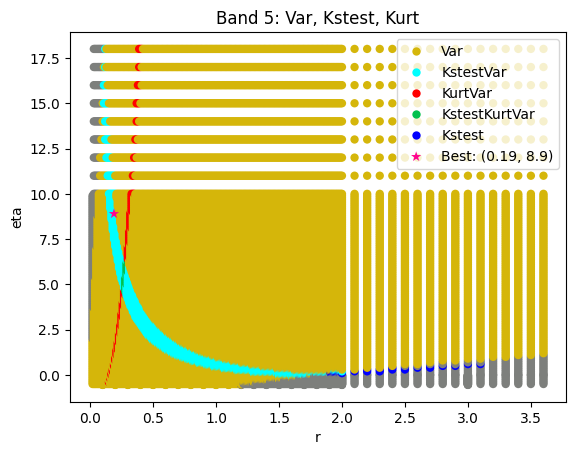

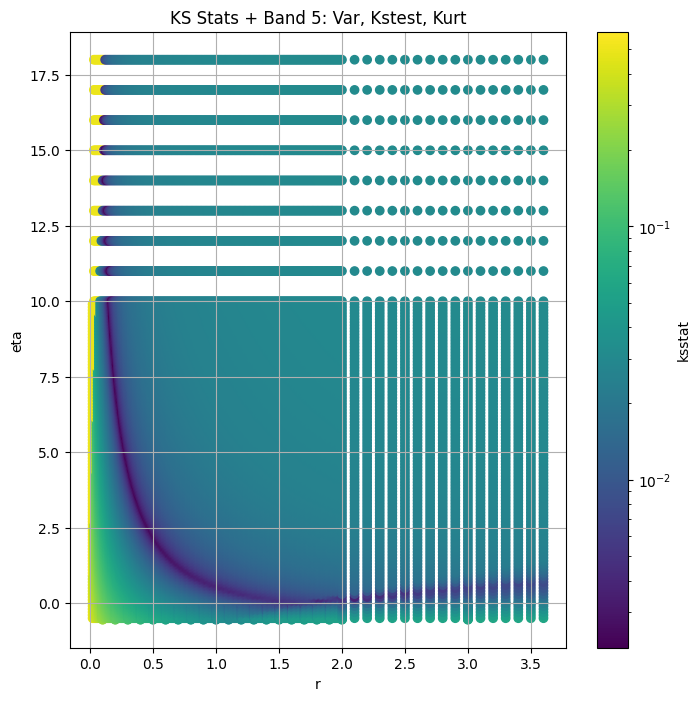

####
Band  8


100%|██████████| 55966/55966 [12:31<00:00, 74.46it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 66780, Without approximation : 66780.0


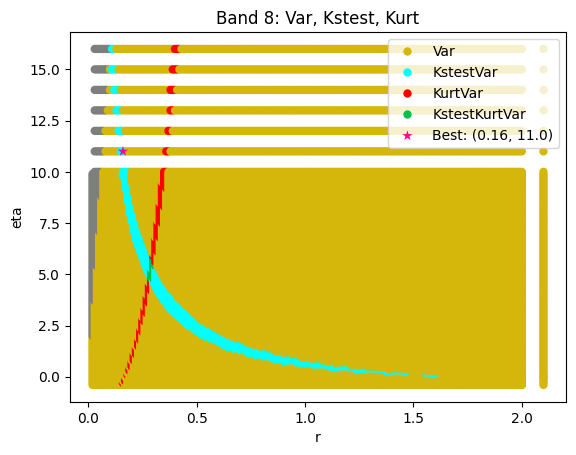

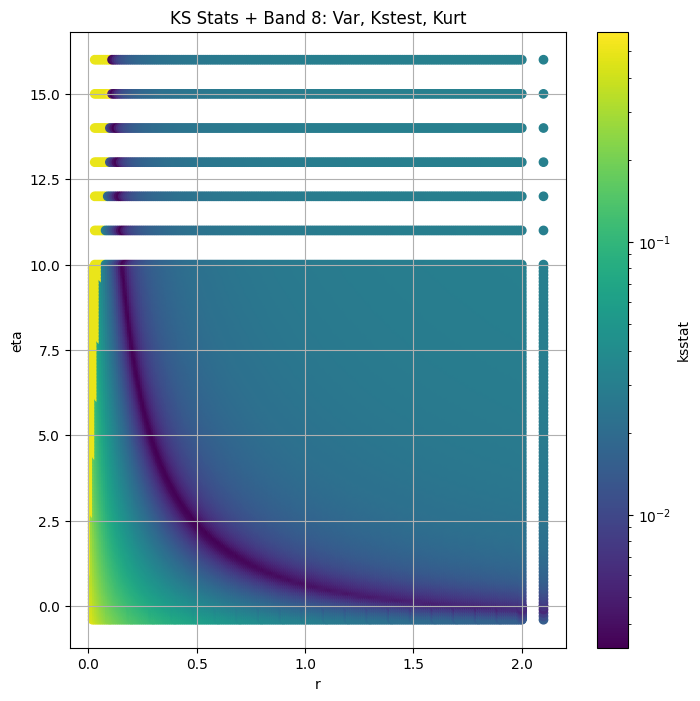

####
Band  11


100%|██████████| 55966/55966 [17:04<00:00, 54.63it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 104940.0


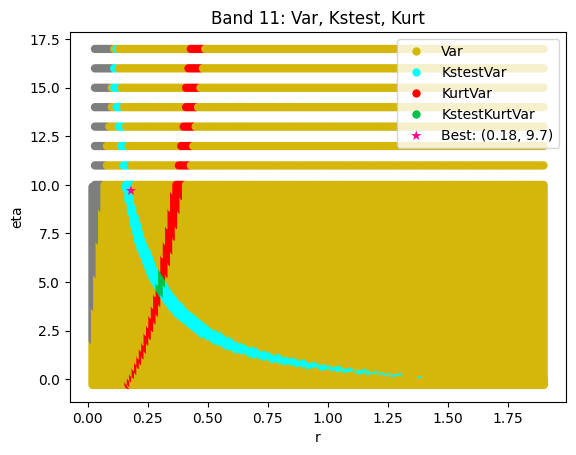

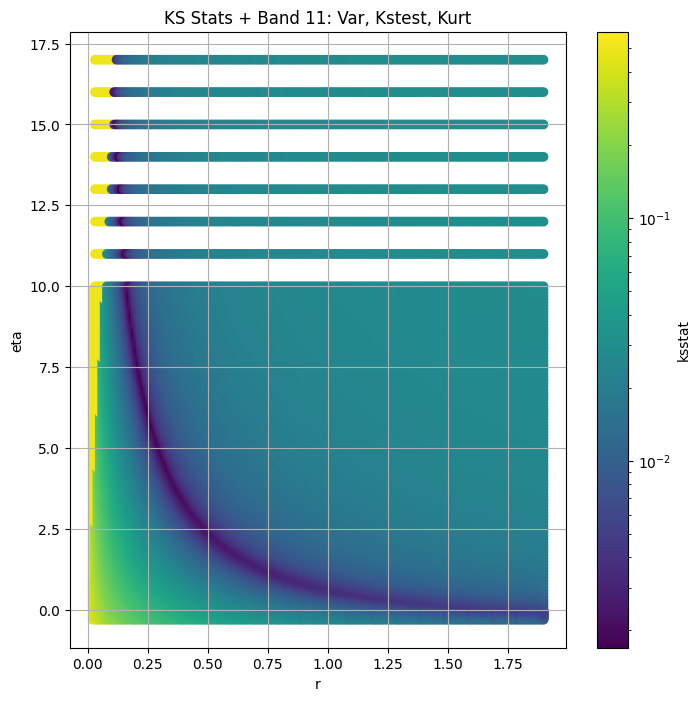

####
Band  14


100%|██████████| 55966/55966 [16:54<00:00, 55.17it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 162180.0


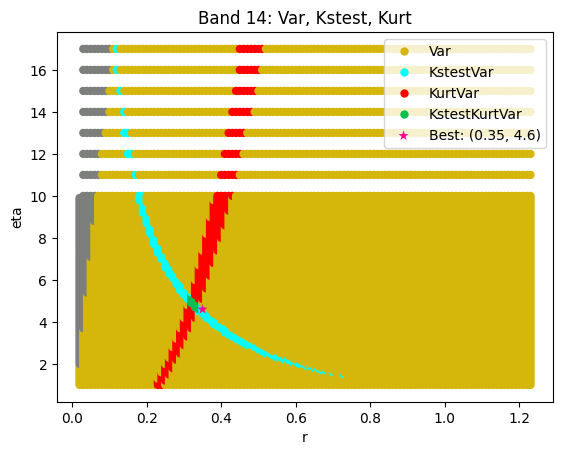

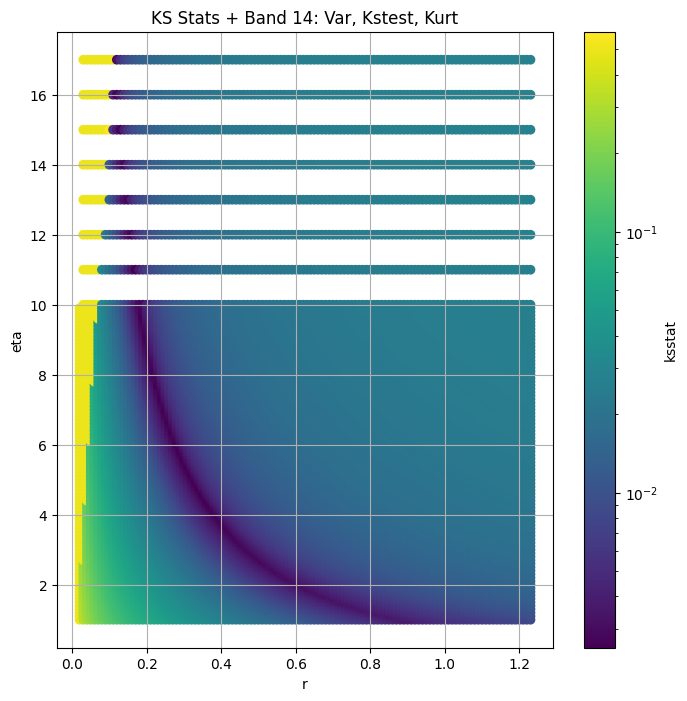

####
Band  17


100%|██████████| 55966/55966 [16:49<00:00, 55.46it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 257580.0


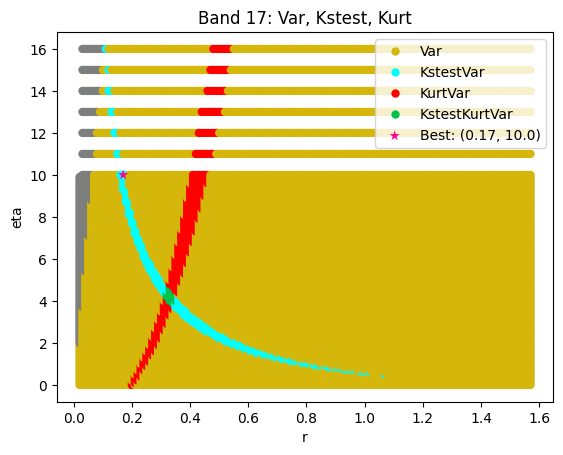

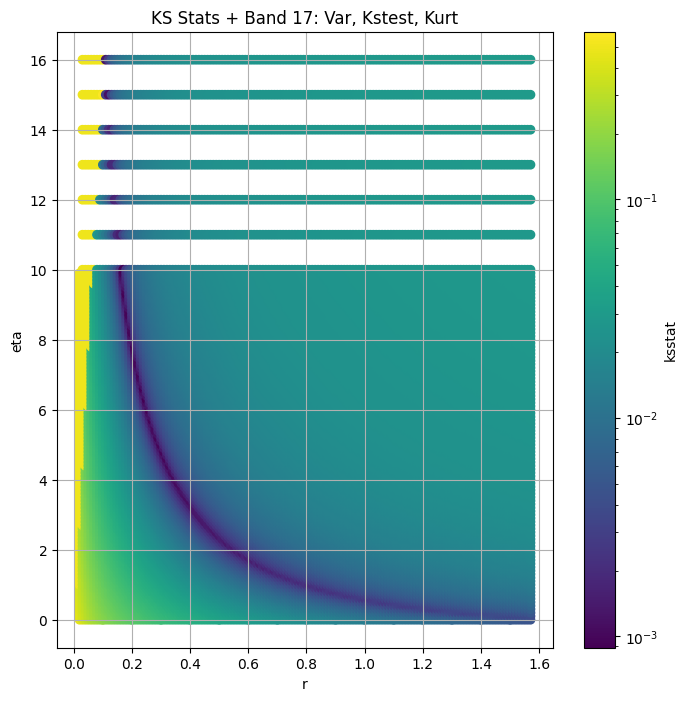

####
Band  20


100%|██████████| 55966/55966 [17:09<00:00, 54.34it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 381600.0


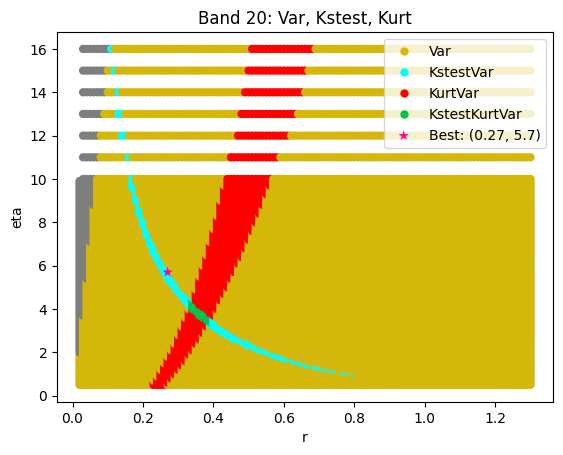

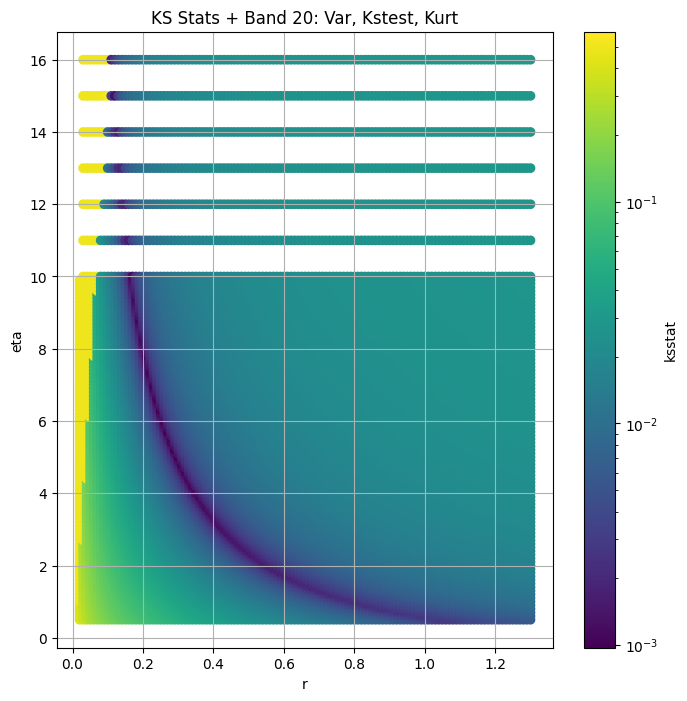

####
Band  23


100%|██████████| 55966/55966 [16:55<00:00, 55.11it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 610560.0


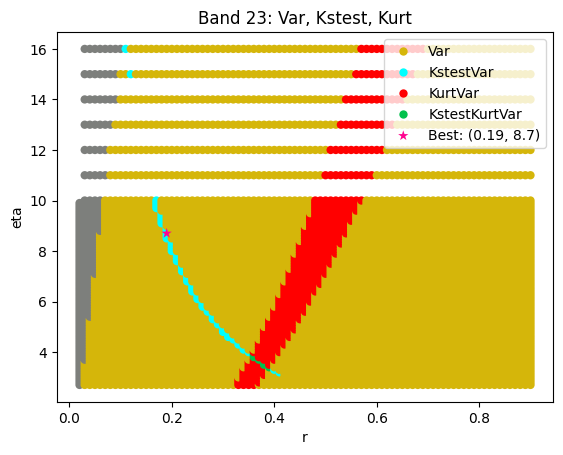

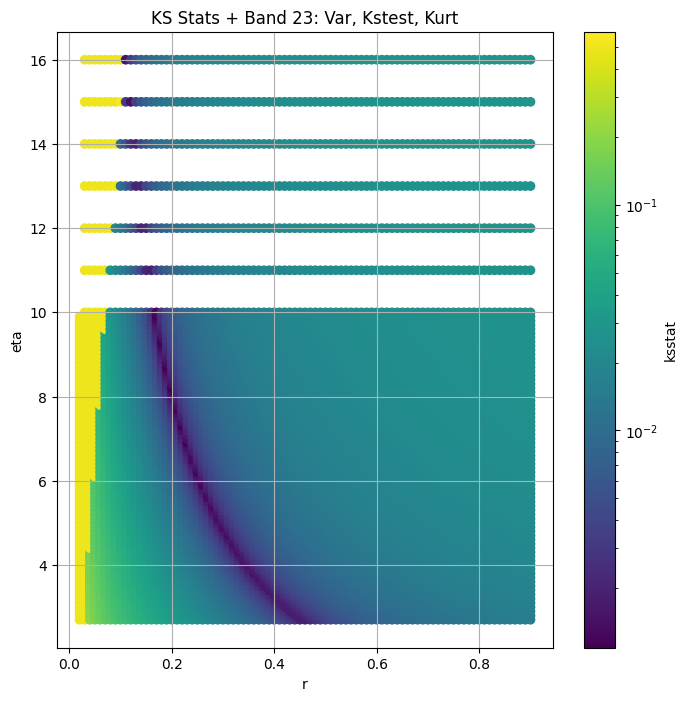

####
Band  26


100%|██████████| 55966/55966 [17:24<00:00, 53.61it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 973080.0


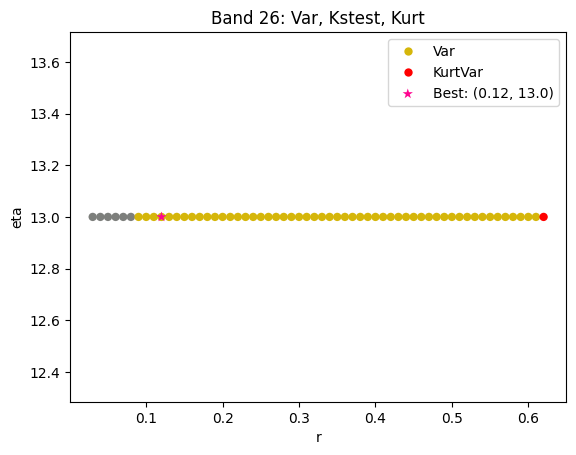

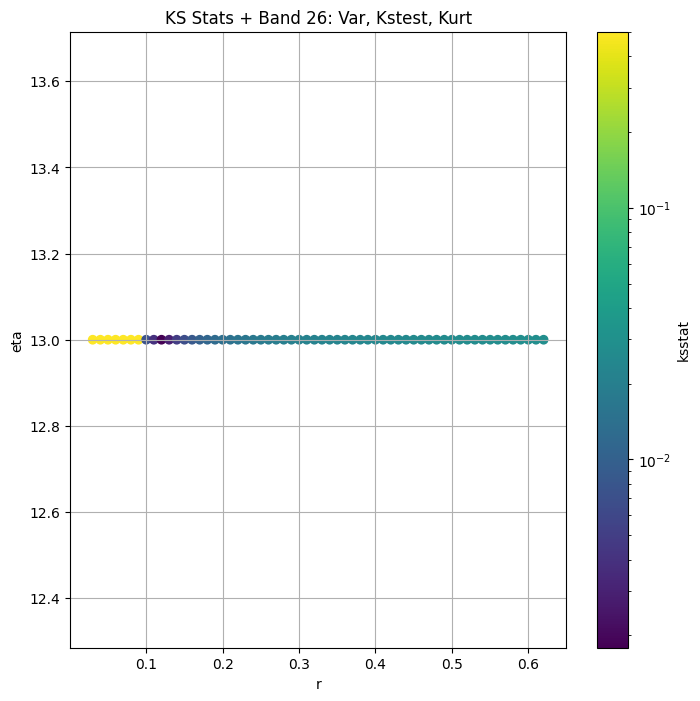

####
Band  29


100%|██████████| 55966/55966 [17:14<00:00, 54.12it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 1376940.0


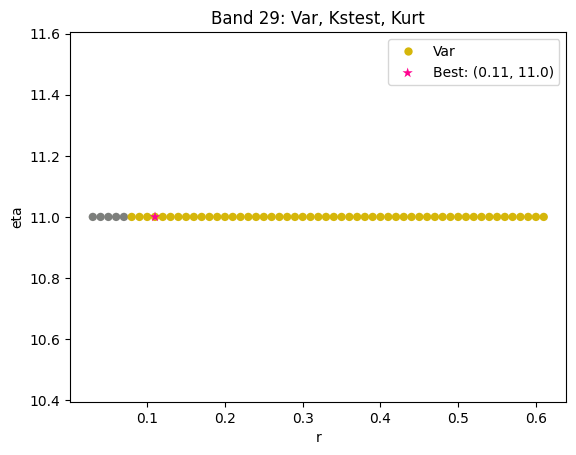

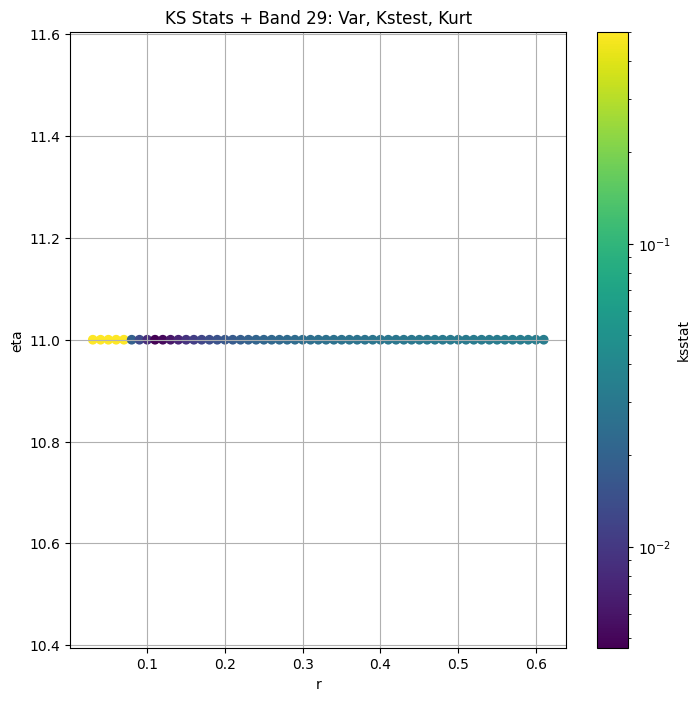

####
Band  32


100%|██████████| 55966/55966 [17:51<00:00, 52.22it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 419760.0


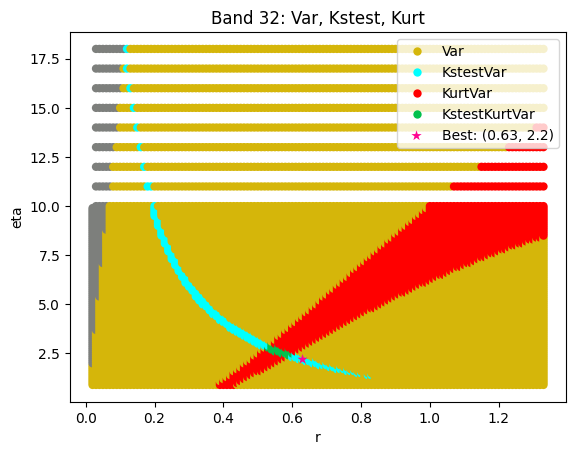

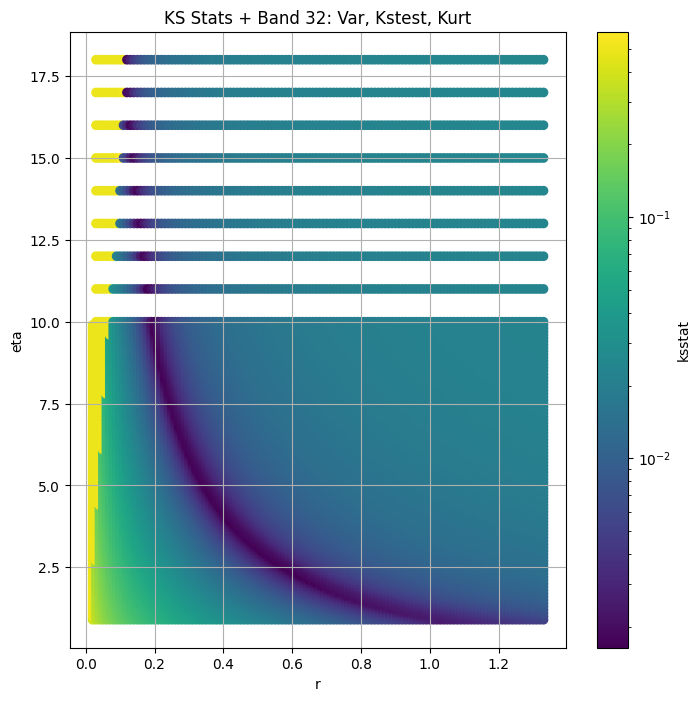

obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
band                                                                       
2     157269.880000  149264.110000  165654.390000   2.019593    1.471349   
5      83422.350000   79257.164000   87787.930000   1.903983    1.275784   
8      45610.926000   43328.332000   47969.348000   1.937604    1.312301   
11     25793.922000   24441.889000   27232.033000   2.370253    1.365877   
14     14051.502000   13346.595000   14808.067000   2.089291    1.275146   
17      7919.142600    7515.967300    8348.544000   2.151878    1.293355   
20      4052.697300    3844.855700    4287.259000   2.416864    1.276760   
23      1979.636500    1878.425500    2088.579000   2.248149    1.370794   
26       868.004900     815.872400     934.296900   4.653831    1.694718   
29       329.394470     302.999200     371.574920  13.155254    2.838861   
32        44.476166      42.376705      46.640842   1.459712    1.005672   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
band                                                                     
2       2.704436        31800.0       0.54          1.8   4.881908e+03   
5       2.832162        41340.0       0.19          8.9   4.851825e-05   
8       2.837549        66780.0       0.16         11.0   5.496529e-08   
11      4.514517       104940.0       0.18          9.7   2.286282e-06   
14      4.009901       162180.0       0.35          4.6   3.451052e+00   
17      4.513294       257580.0       0.17         10.0   1.103242e-07   
20      9.097979       381600.0       0.27          5.7   1.769795e-02   
23      4.596758       610560.0       0.19          8.7   1.270410e-06   
26     18.998148       973080.0       0.12         13.0   3.016086e-15   
29     66.098460      1376940.0       0.11         11.0   4.943743e-17   
32      2.262223       419760.0       0.63          2.2   2.484432e+00   

      kstest_stat_initial  kstest_stat_cutoff_0.05  
band                                                
2                0.003363                 0.007611  
5                0.002174                 0.006675  
8                0.003263                 0.005253  
11               0.001697                 0.004191  
14               0.002544                 0.003371  
17               0.000886                 0.002675  
20               0.000972                 0.002198  
23               0.001089                 0.001738  
26               0.001785                 0.001377  
29               0.004639                 0.001157  
32               0.001634                 0.002096

In [10]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        
        group_cdf_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / group_cdf_df['variance'], 0, 1e5)
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
        initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        master_df.loc[group, 'initial_scale'] = initial_scale
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df['variance'] = group_cdf_df['variance'] * group_cdf_df['scale']
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * group_cdf_df['scale']

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = None,
                            best_param = initial_param)
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [11]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True, scales=group_cdf_df['scale'])
            best_scale_eta0 = group_cdf_df.loc[(group_cdf_df["r"] ==  best_param_eta0[0]) & (group_cdf_df["eta"] ==  best_param_eta0[1])]["scale"].iloc[0]
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'best_scale_eta0'] = best_scale_eta0
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_scale_eta0'] = master_df.loc[group, 'initial_scale']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:02<00:00, 152.49it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:03<00:00, 96.69it/s] 


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:04<00:00, 89.62it/s] 


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:06<00:00, 54.13it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:07<00:00, 48.09it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:06<00:00, 54.03it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:07<00:00, 49.31it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:07<00:00, 49.42it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:06<00:00, 53.90it/s] 


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:06<00:00, 53.13it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:06<00:00, 52.97it/s]

Finding Minimum after computing 369 CDFs


obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
band                                                                       
2     157269.880000  149264.110000  165654.390000   2.019593    1.471349   
5      83422.350000   79257.164000   87787.930000   1.903983    1.275784   
8      45610.926000   43328.332000   47969.348000   1.937604    1.312301   
11     25793.922000   24441.889000   27232.033000   2.370253    1.365877   
14     14051.502000   13346.595000   14808.067000   2.089291    1.275146   
17      7919.142600    7515.967300    8348.544000   2.151878    1.293355   
20      4052.697300    3844.855700    4287.259000   2.416864    1.276760   
23      1979.636500    1878.425500    2088.579000   2.248149    1.370794   
26       868.004900     815.872400     934.296900   4.653831    1.694718   
29       329.394470     302.999200     371.574920  13.155254    2.838861   
32        44.476166      42.376705      46.640842   1.459712    1.005672   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
band                                                                     
2       2.704436        31800.0       0.54          1.8   4.881908e+03   
5       2.832162        41340.0       0.19          8.9   4.851825e-05   
8       2.837549        66780.0       0.16         11.0   5.496529e-08   
11      4.514517       104940.0       0.18          9.7   2.286282e-06   
14      4.009901       162180.0       0.35          4.6   3.451052e+00   
17      4.513294       257580.0       0.17         10.0   1.103242e-07   
20      9.097979       381600.0       0.27          5.7   1.769795e-02   
23      4.596758       610560.0       0.19          8.7   1.270410e-06   
26     18.998148       973080.0       0.12         13.0   3.016086e-15   
29     66.098460      1376940.0       0.11         11.0   4.943743e-17   
32      2.262223       419760.0       0.63          2.2   2.484432e+00   

      kstest_stat_initial  kstest_stat_cutoff_0.05  best_r_eta0  \
band                                                              
2                0.003363                 0.007611         0.93   
5                0.002174                 0.006675         1.67   
8                0.003263                 0.005253         6.00   
11               0.001697                 0.004191         6.00   
14               0.002544                 0.003371         6.00   
17               0.000886                 0.002675         6.00   
20               0.000972                 0.002198         6.00   
23               0.001089                 0.001738         6.00   
26               0.001785                 0.001377         5.90   
29               0.004639                 0.001157         5.90   
32               0.001634                 0.002096         5.80   

      best_scale_eta0  kstest_stat_eta0  
band                                     
2           26.013919          0.008560  
5           53.708767          0.005462  
8           75.792669          0.040336  
11          75.792669          0.099728  
14          75.792669          0.160225  
17          75.792669          0.212573  
20          75.792669          0.267704  
23          75.792669          0.317583  
26          75.742331          0.364927  
29          75.742331          0.407773  
32          75.688014          0.457712

## Optimization

In [12]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Band 2


100%|██████████| 441/441 [00:01<00:00, 283.76it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 2 best parameters: ((0.538, 1.81), 0.003356055444899253)


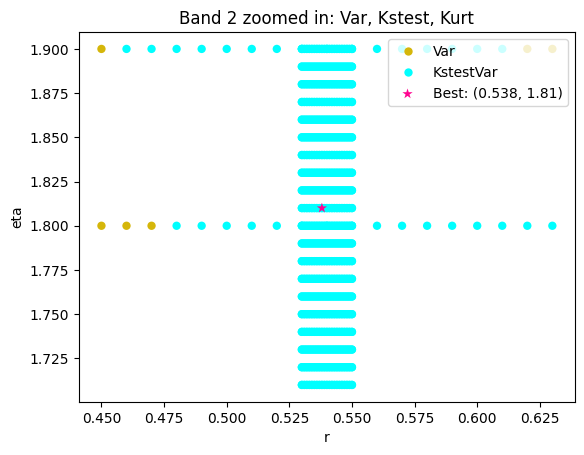

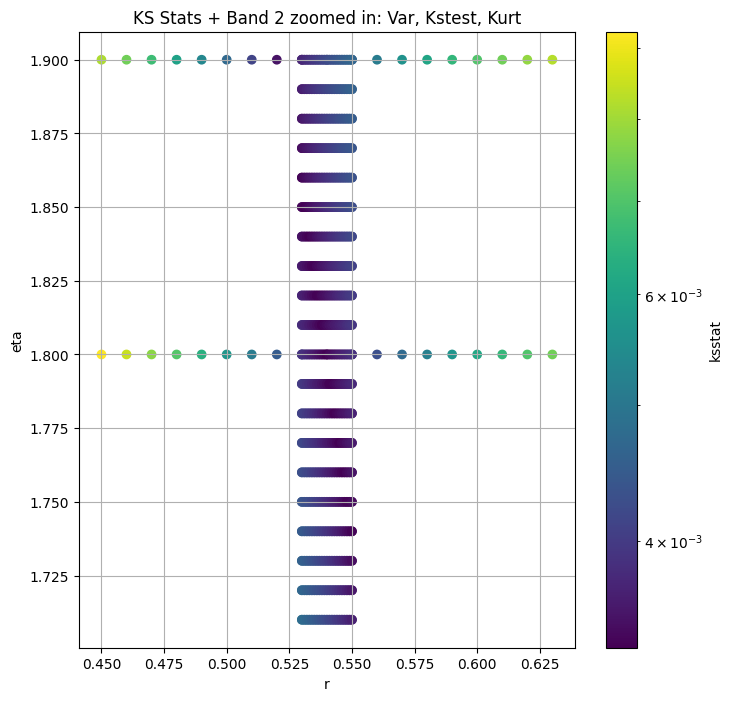

Band 5


100%|██████████| 420/420 [00:02<00:00, 144.51it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 5 best parameters: ((0.191, 8.84), 0.0021662190243704194)


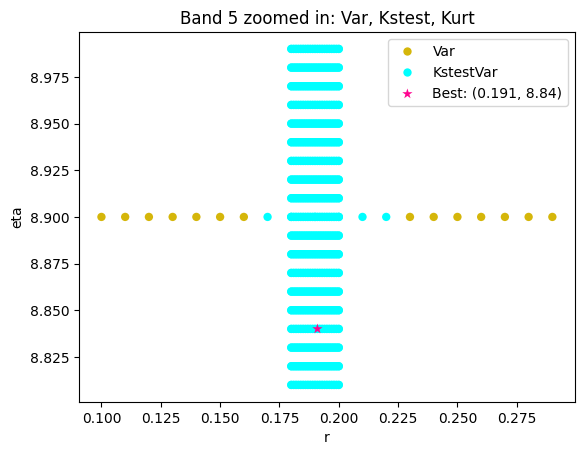

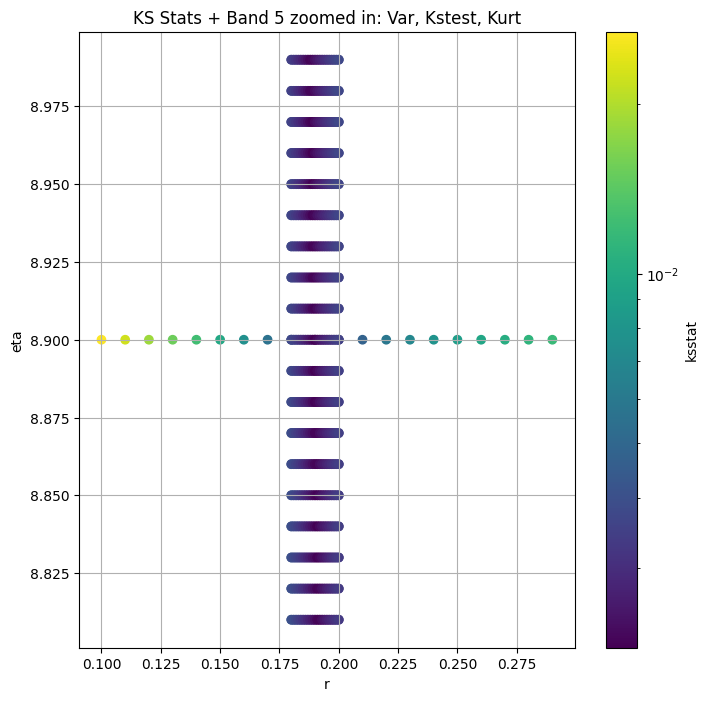

Band 8


100%|██████████| 420/420 [00:04<00:00, 84.92it/s] 


Finding Minimum after computing 420 CDFs
Iter 1 band 8 best parameters: ((0.155, 11.4), 0.003262496610835053)


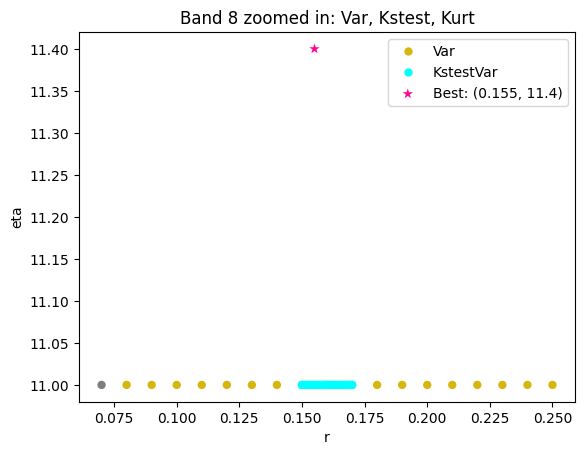

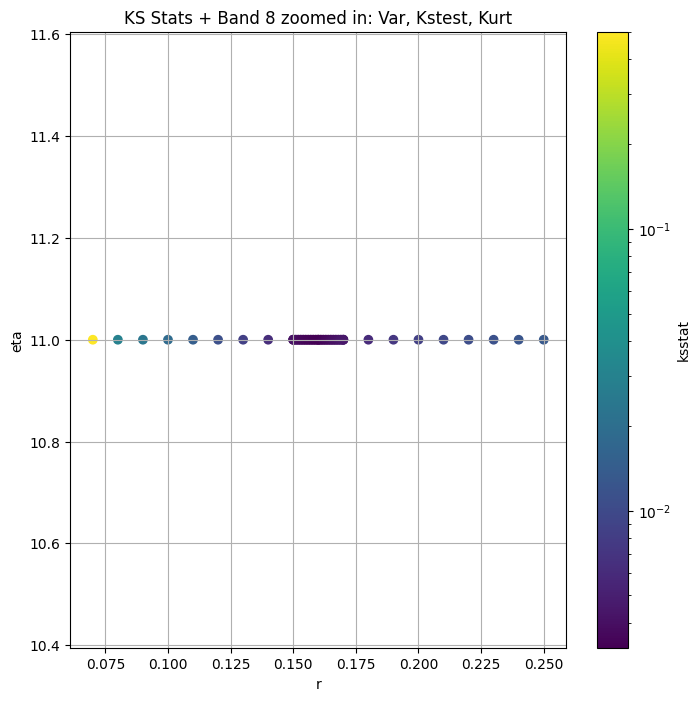

Band 11


100%|██████████| 420/420 [00:05<00:00, 75.26it/s] 


Finding Minimum after computing 420 CDFs
Iter 1 band 11 best parameters: ((0.179, 9.78), 0.0016777669876130163)


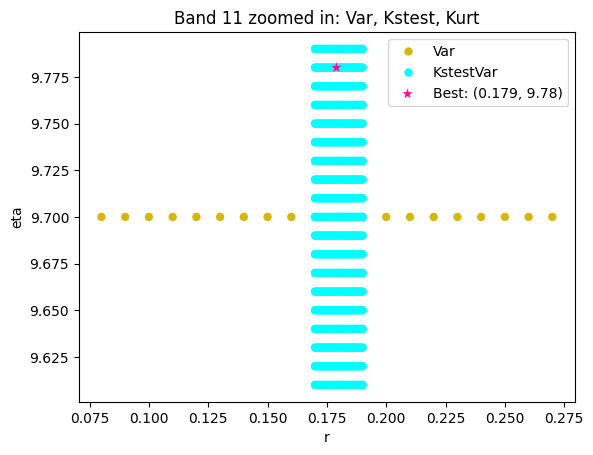

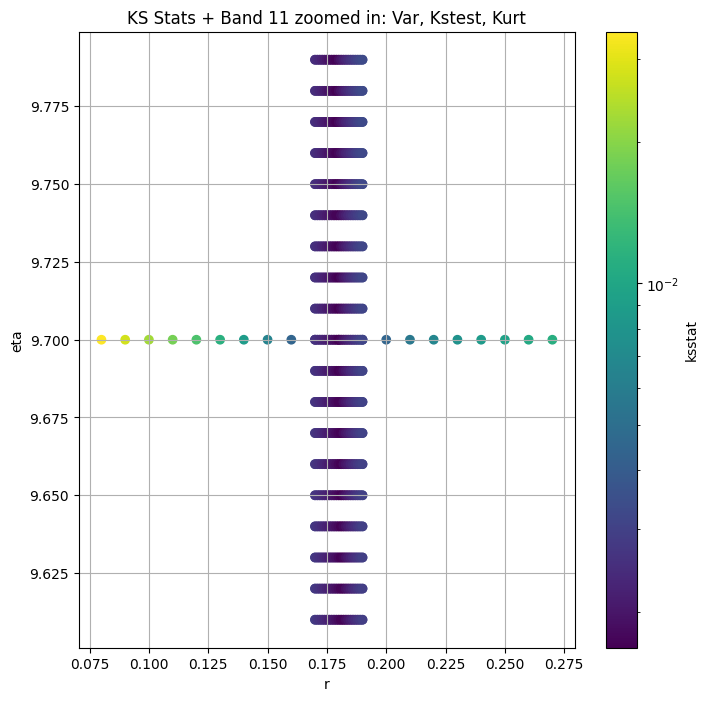

Band 14


100%|██████████| 420/420 [00:06<00:00, 60.83it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 14 best parameters: ((0.349, 4.62), 0.002536586462869972)


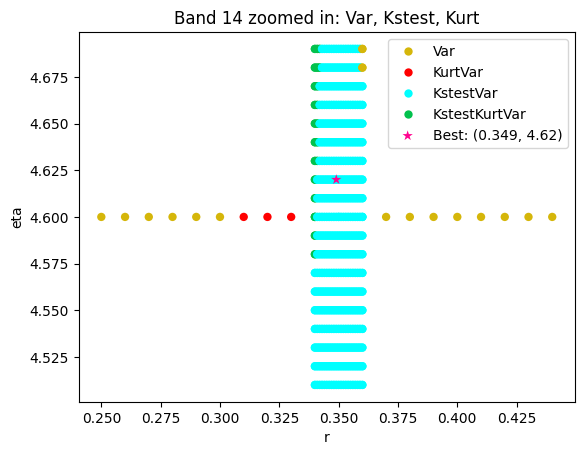

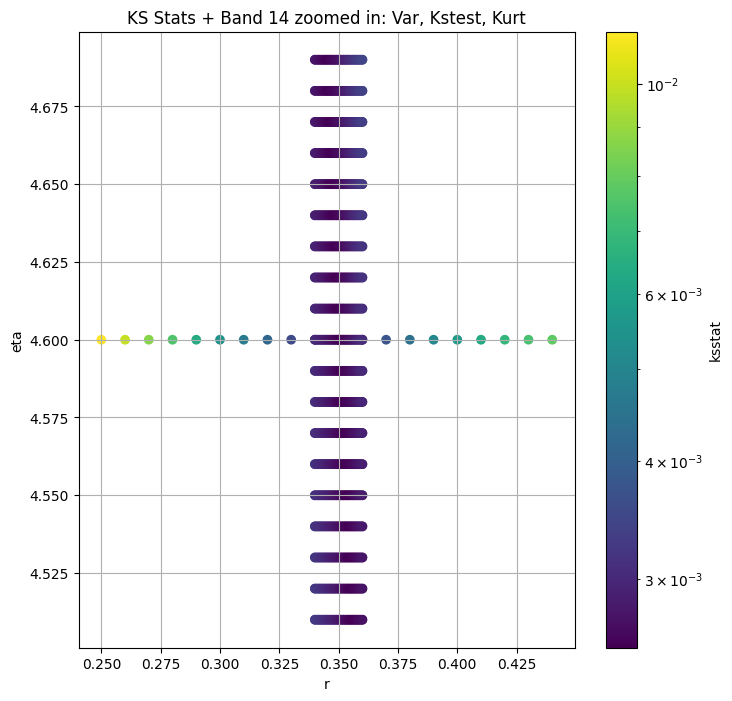

Band 17


100%|██████████| 420/420 [00:05<00:00, 74.22it/s] 


Finding Minimum after computing 420 CDFs
Iter 1 band 17 best parameters: ((0.164, 10.4), 0.0008384496329479907)


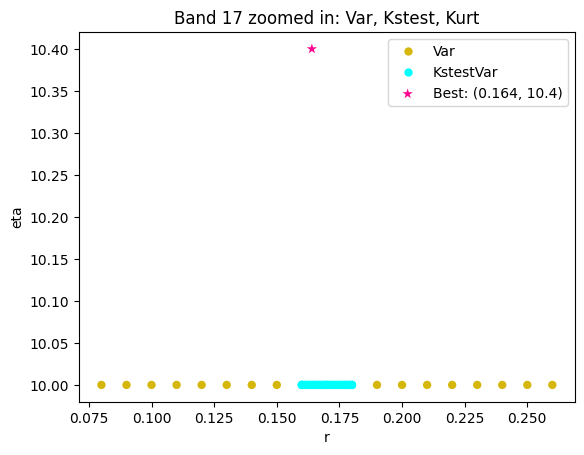

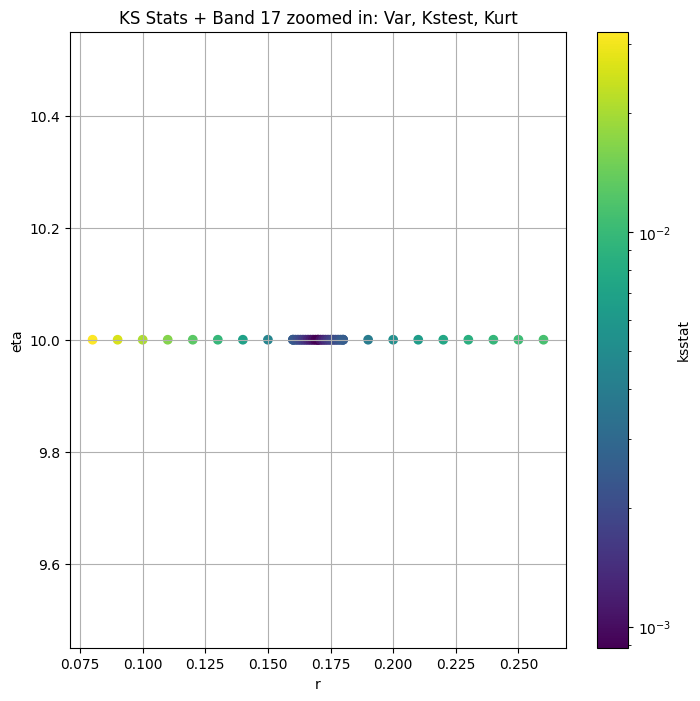

Band 20


100%|██████████| 420/420 [00:06<00:00, 60.98it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 20 best parameters: ((0.27, 5.71), 0.0009351583480399217)


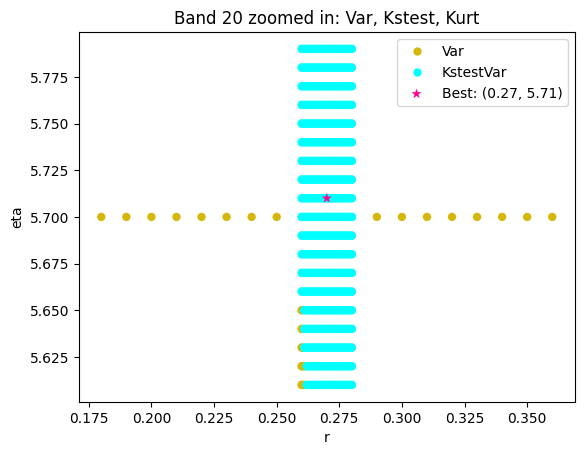

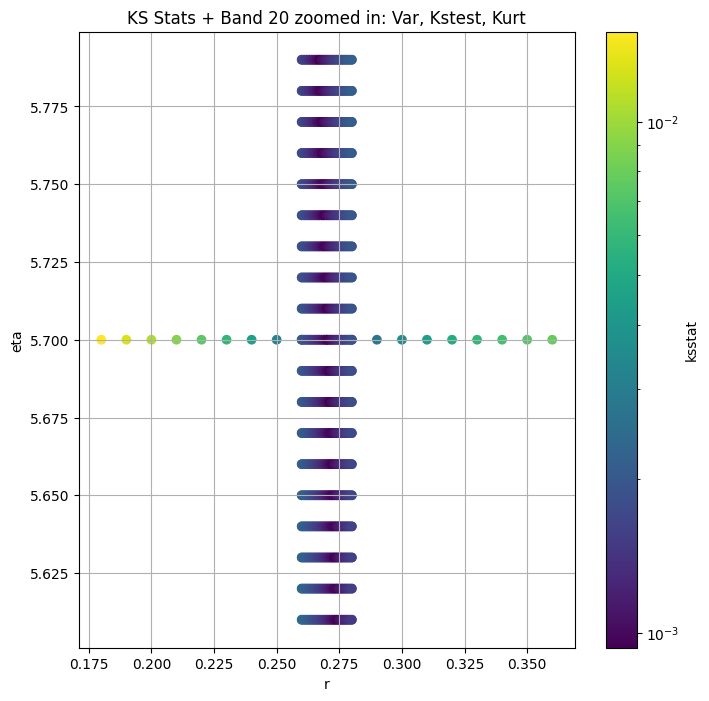

Band 23


100%|██████████| 420/420 [00:06<00:00, 67.84it/s] 


Finding Minimum after computing 420 CDFs
Iter 1 band 23 best parameters: ((0.189, 8.76), 0.001073358034867855)


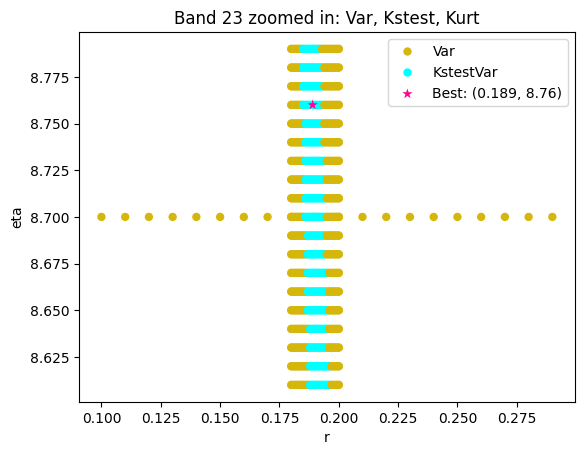

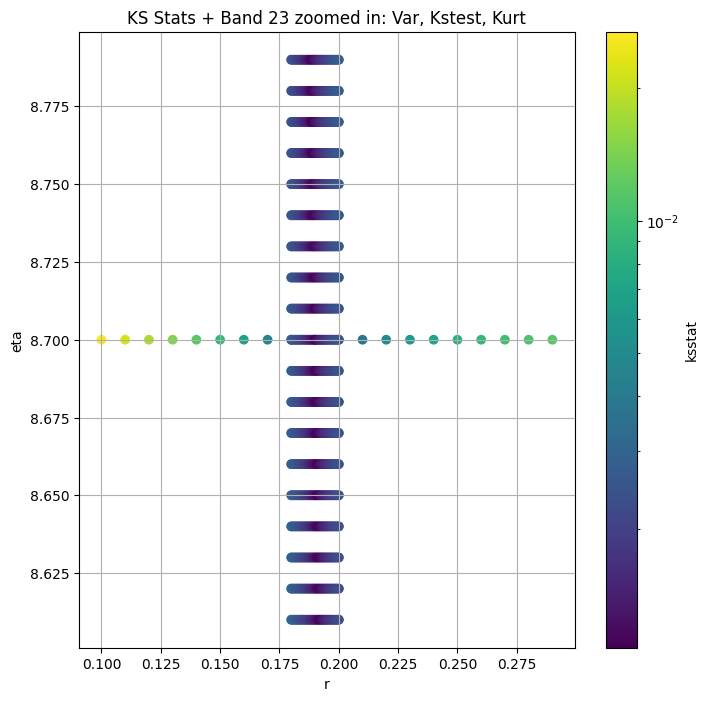

Band 26


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
100%|██████████| 420/420 [00:06<00:00, 62.11it/s]
C:\Users\yashd\AppData\Local\Temp\ipykernel_36108\3557979055.py:35: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.scatterplot(df, x='r', y=

Finding Minimum after computing 420 CDFs
Iter 1 band 26 best parameters: ((0.112, 13.8), 0.0016977292488176143)


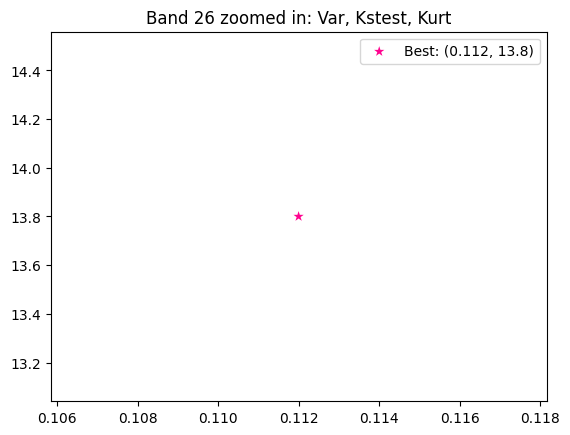

Band 29
(0.102, 10.9), 50 of 400
(0.104, 11.9), 100 of 400
(0.107, 10.9), 150 of 400
(0.109, 11.9), 200 of 400
(0.112, 10.9), 250 of 400
(0.114, 11.9), 300 of 400
(0.117, 10.9), 350 of 400
(0.119, 11.9), 400 of 400


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
100%|██████████| 400/400 [00:06<00:00, 57.21it/s]
C:\Users\yashd\AppData\Local\Temp\ipykernel_36108\3557979055.py:35: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.scatterplot(df, x='r', y=

Finding Minimum after computing 400 CDFs
Iter 1 band 29 best parameters: ((0.102, 11.9), 0.0045798218414235675)


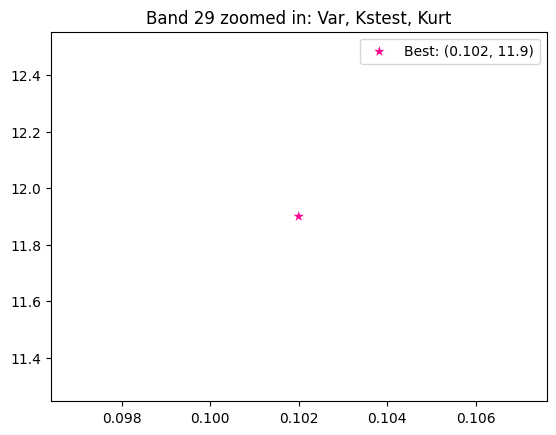

Band 32
(0.622, 2.17), 50 of 441
(0.624, 2.25), 100 of 441
(0.627, 2.12), 150 of 441
(0.629, 2.2), 200 of 441
(0.631, 2.28), 250 of 441
(0.634, 2.15), 300 of 441
(0.636, 2.23), 350 of 441
(0.639, 2.1), 400 of 441


100%|██████████| 441/441 [00:08<00:00, 51.51it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 32 best parameters: ((0.632, 2.19), 0.001631183322280516)


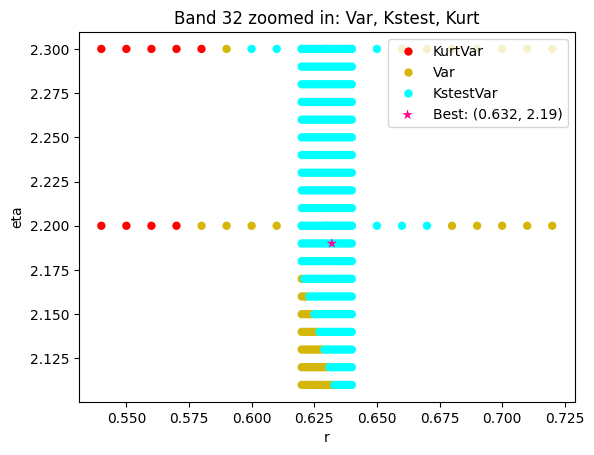

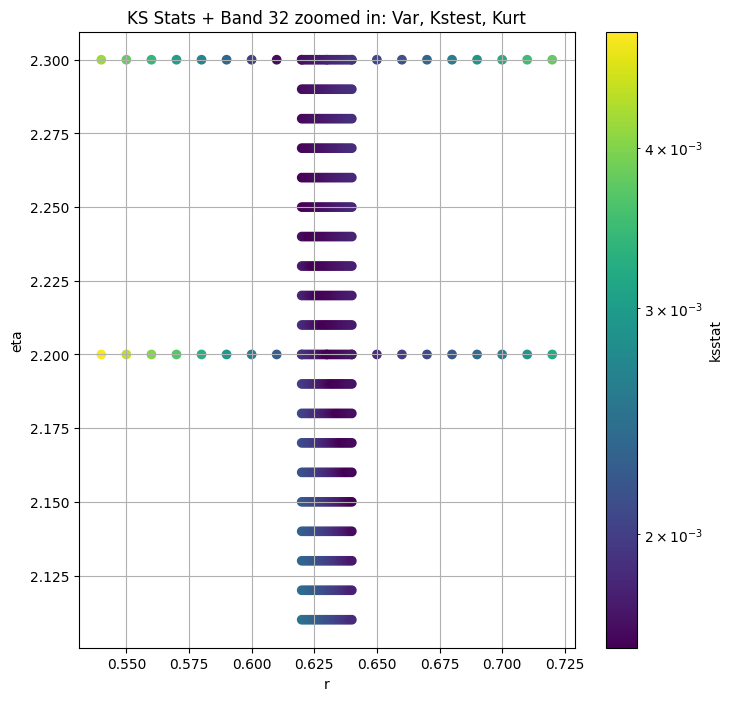

obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
band                                                                       
2     157269.880000  149264.110000  165654.390000   2.019593    1.471349   
5      83422.350000   79257.164000   87787.930000   1.903983    1.275784   
8      45610.926000   43328.332000   47969.348000   1.937604    1.312301   
11     25793.922000   24441.889000   27232.033000   2.370253    1.365877   
14     14051.502000   13346.595000   14808.067000   2.089291    1.275146   
17      7919.142600    7515.967300    8348.544000   2.151878    1.293355   
20      4052.697300    3844.855700    4287.259000   2.416864    1.276760   
23      1979.636500    1878.425500    2088.579000   2.248149    1.370794   
26       868.004900     815.872400     934.296900   4.653831    1.694718   
29       329.394470     302.999200     371.574920  13.155254    2.838861   
32        44.476166      42.376705      46.640842   1.459712    1.005672   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                                    ...   
2       2.704436        31800.0       0.54          1.8   4.881908e+03  ...   
5       2.832162        41340.0       0.19          8.9   4.851825e-05  ...   
8       2.837549        66780.0       0.16         11.0   5.496529e-08  ...   
11      4.514517       104940.0       0.18          9.7   2.286282e-06  ...   
14      4.009901       162180.0       0.35          4.6   3.451052e+00  ...   
17      4.513294       257580.0       0.17         10.0   1.103242e-07  ...   
20      9.097979       381600.0       0.27          5.7   1.769795e-02  ...   
23      4.596758       610560.0       0.19          8.7   1.270410e-06  ...   
26     18.998148       973080.0       0.12         13.0   3.016086e-15  ...   
29     66.098460      1376940.0       0.11         11.0   4.943743e-17  ...   
32      2.262223       419760.0       0.63          2.2   2.484432e+00  ...   

      best_scale_eta0  kstest_stat_eta0  best_r  best_eta    best_scale  \
band                                                                      
2           26.013919          0.008560   0.538      1.81  4.758504e+03   
5           53.708767          0.005462   0.191      8.84  5.740764e-05   
8           75.792669          0.040336   0.155     11.40  1.515838e-08   
11          75.792669          0.099728   0.179      9.78  1.873615e-06   
14          75.792669          0.160225   0.349      4.62  3.311903e+00   
17          75.792669          0.212573   0.164     10.40  2.898767e-08   
20          75.792669          0.267704   0.270      5.71  1.761146e-02   
23          75.792669          0.317583   0.189      8.76  1.071764e-06   
26          75.742331          0.364927   0.112     13.80  5.774491e-17   
29          75.742331          0.407773   0.102     11.90  4.061152e-19   
32          75.688014          0.457712   0.632      2.19  2.531163e+00   

      kstest_stat_best  iter1_r  iter1_eta  kstest_stat_iter1  n_pval_0.05  
band                                                                        
2             0.003356    0.538       1.81           0.003356       160987  
5             0.002166    0.191       8.84           0.002166       397309  
8             0.003262    0.155      11.40           0.003262       169036  
11            0.001678    0.179       9.78           0.001678       672372  
14            0.002537    0.349       4.62           0.002537       273678  
17            0.000838    0.164      10.40           0.000838      2643573  
20            0.000935    0.270       5.71           0.000935      2173330  
23            0.001073    0.189       8.76           0.001073      1545480  
26            0.001698    0.112      13.80           0.001698       615775  
29            0.004580    0.102      11.90           0.004580        86058  
32            0.001631    0.632       2.19           0.001631       708345  

[11 rows x 23 col

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / temp_df['variance'], 0, 1e5)
                temp_df['variance'] = temp_df['variance'] * temp_df['scale']
                temp_df['kurtosis'] = temp_df['kurtosis'] * temp_df['scale']
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True, scales=temp_df['scale'])
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                best_scale = temp_df.loc[(temp_df["r"] ==  best_param[0])&(temp_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'best_scale'] = best_scale
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

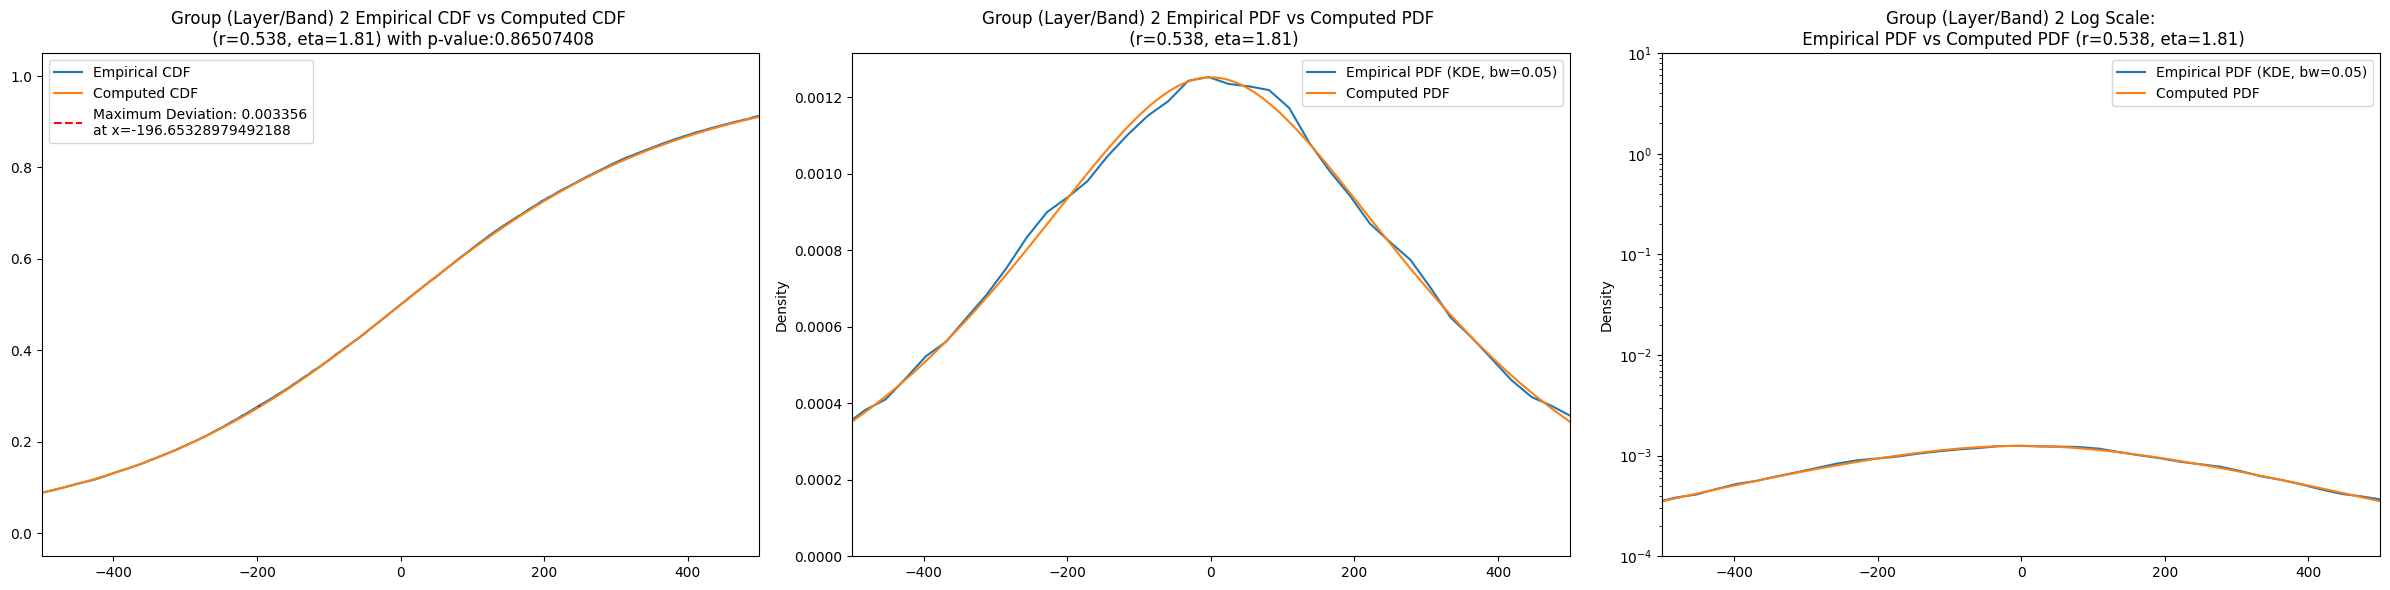

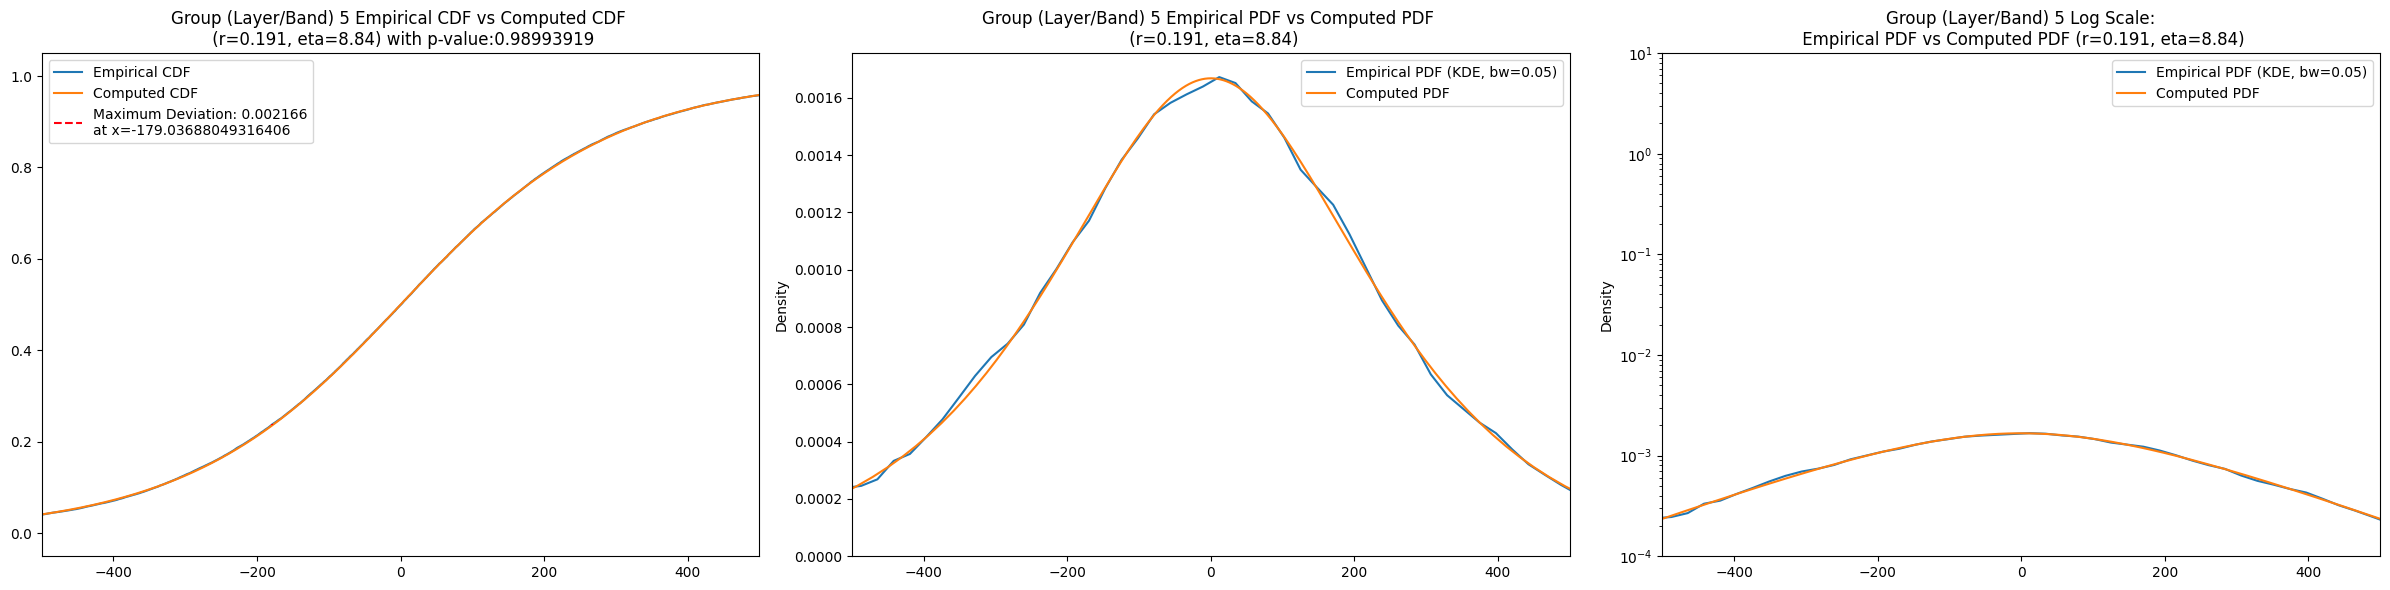

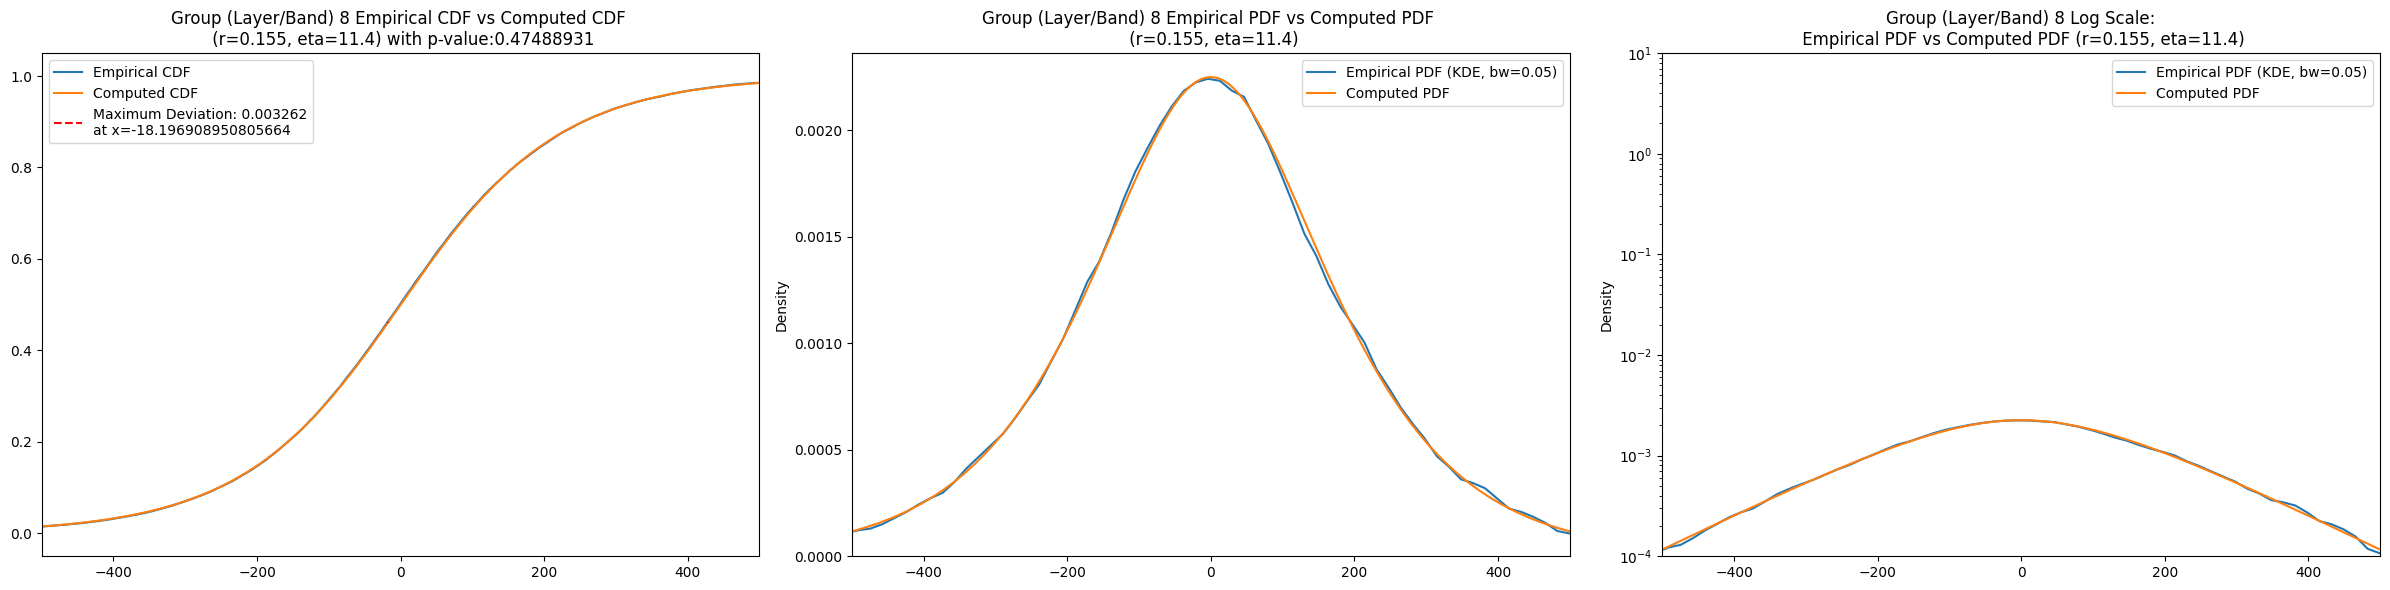

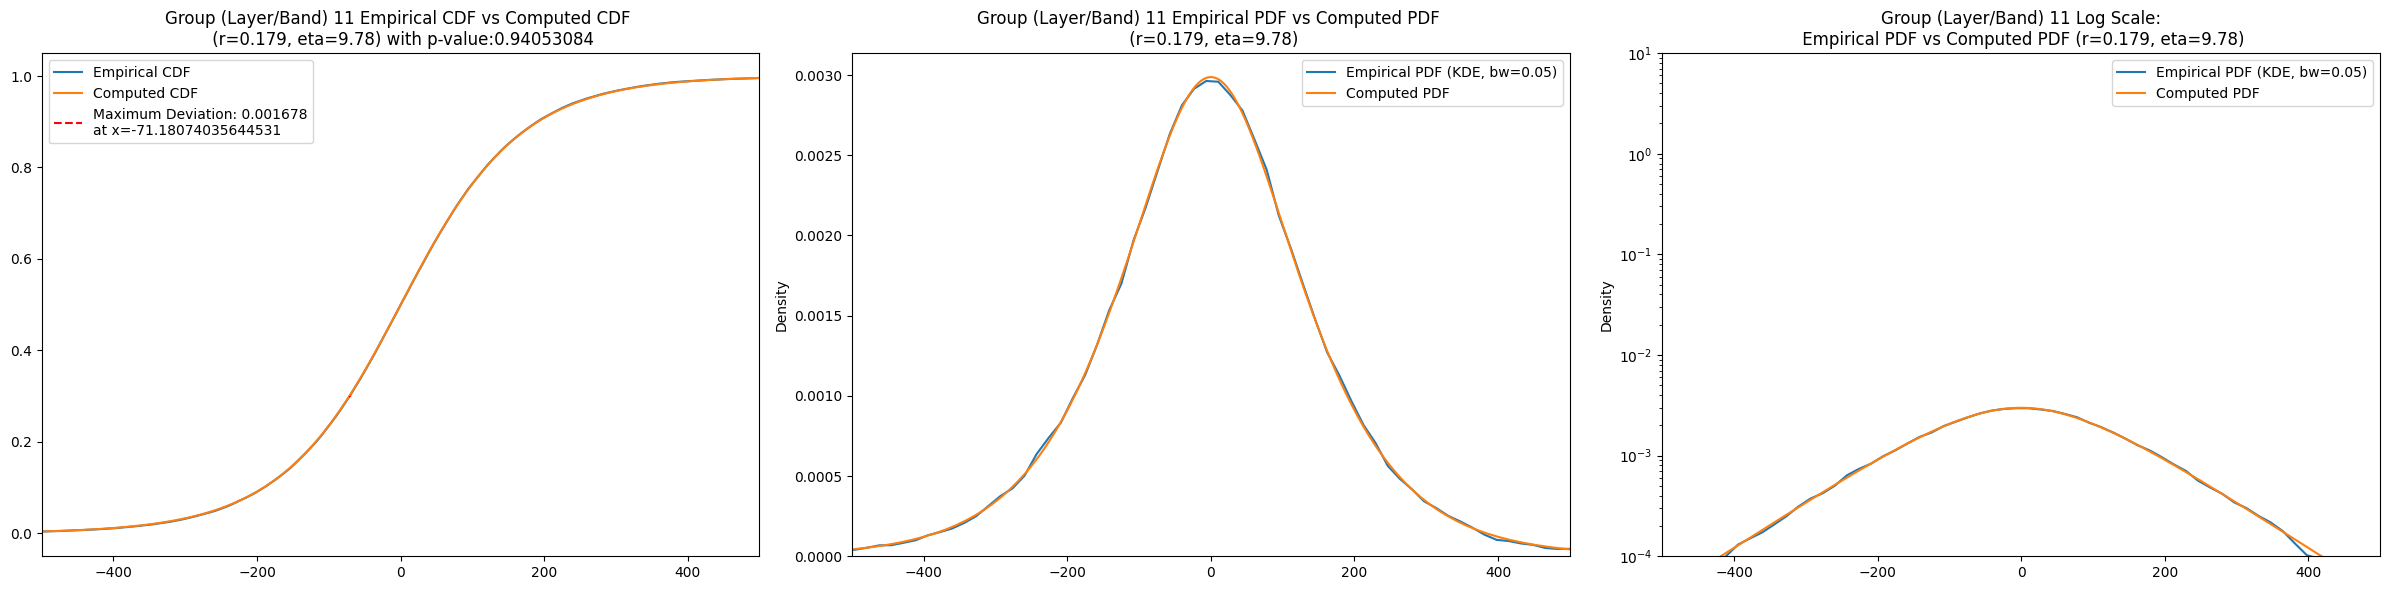

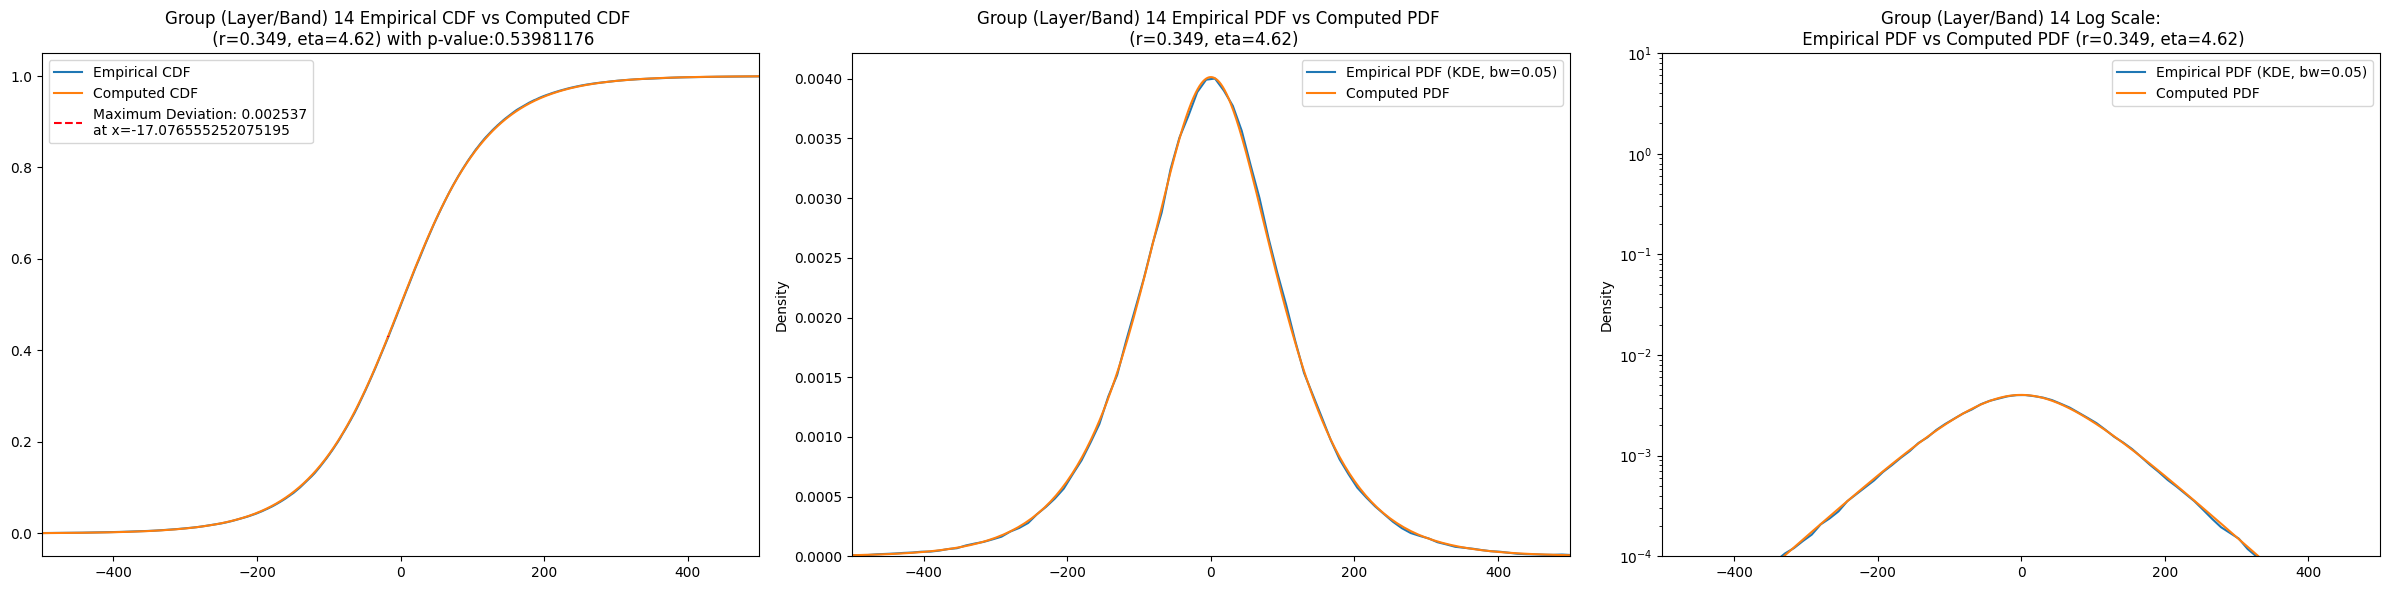

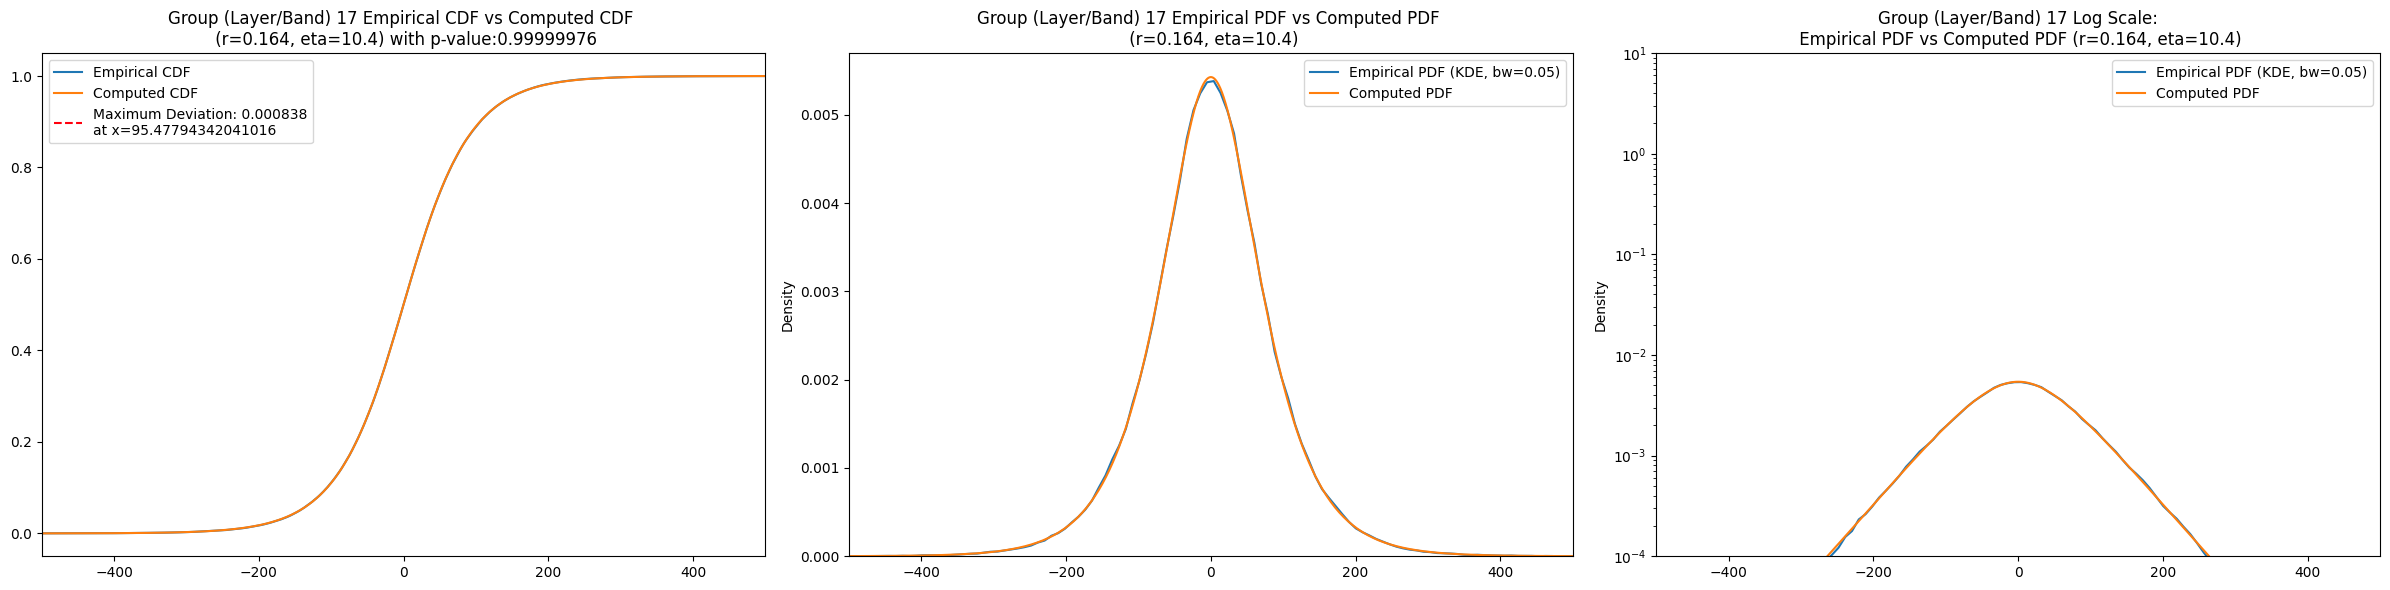

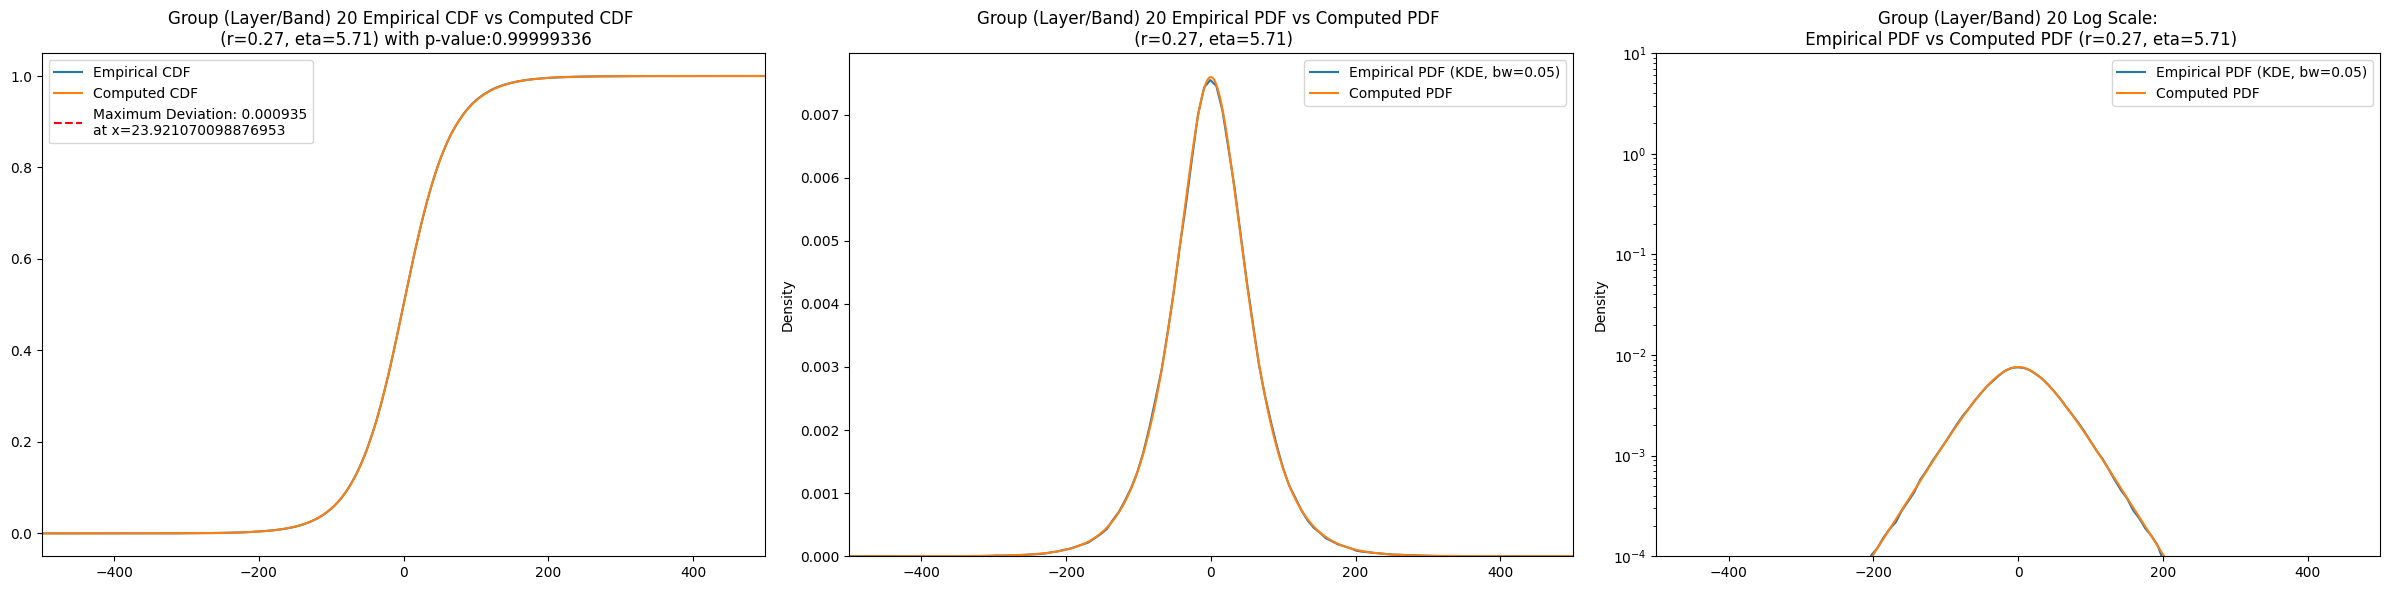

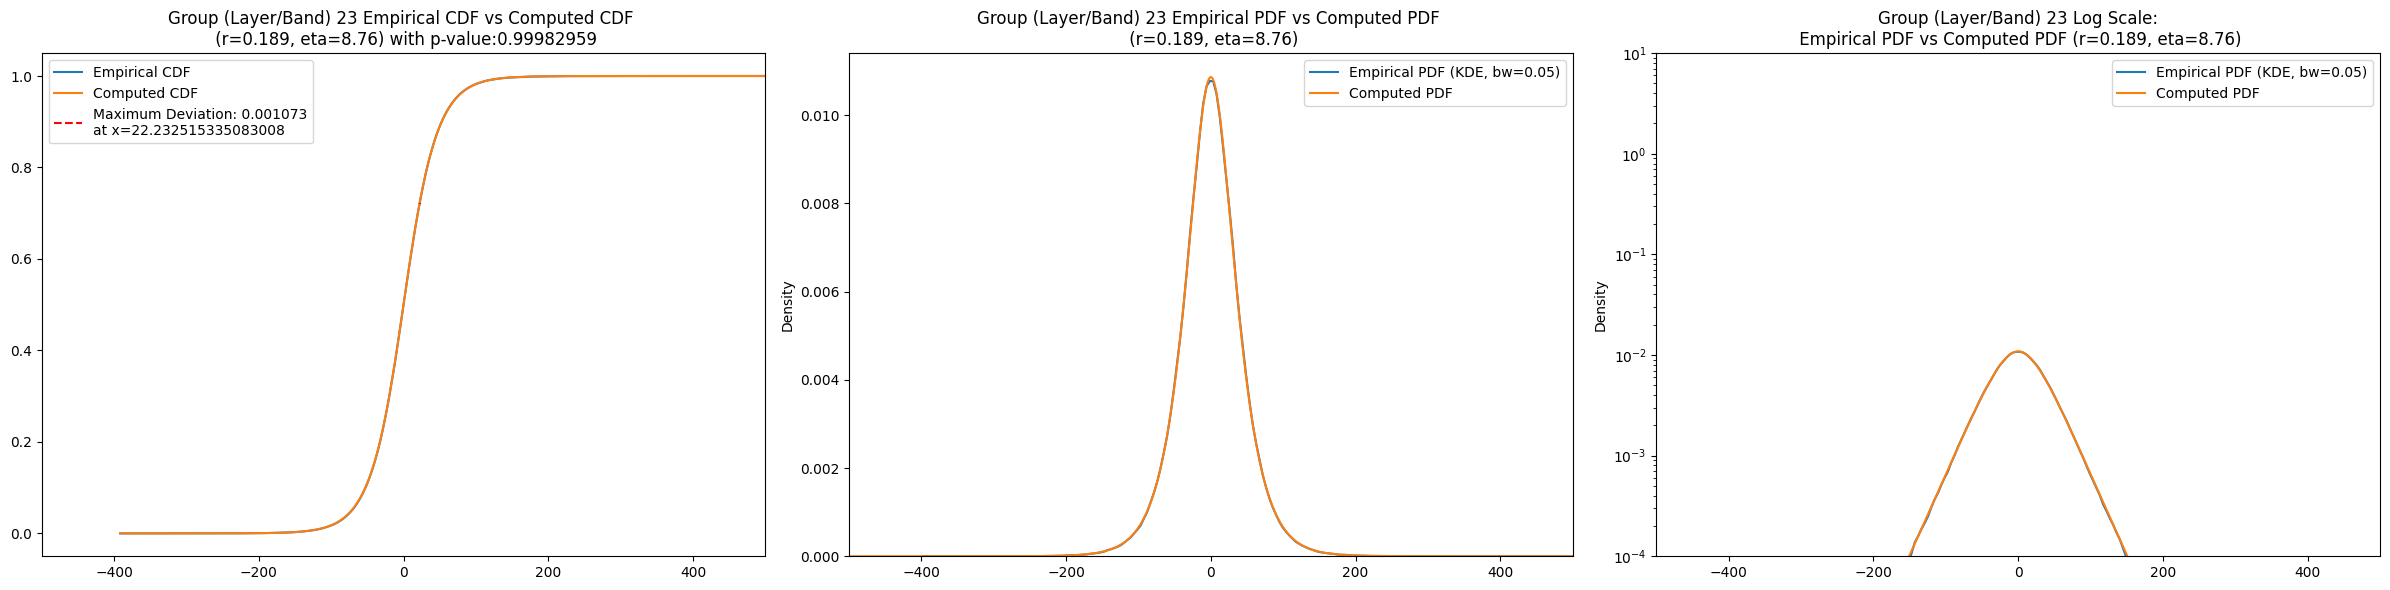

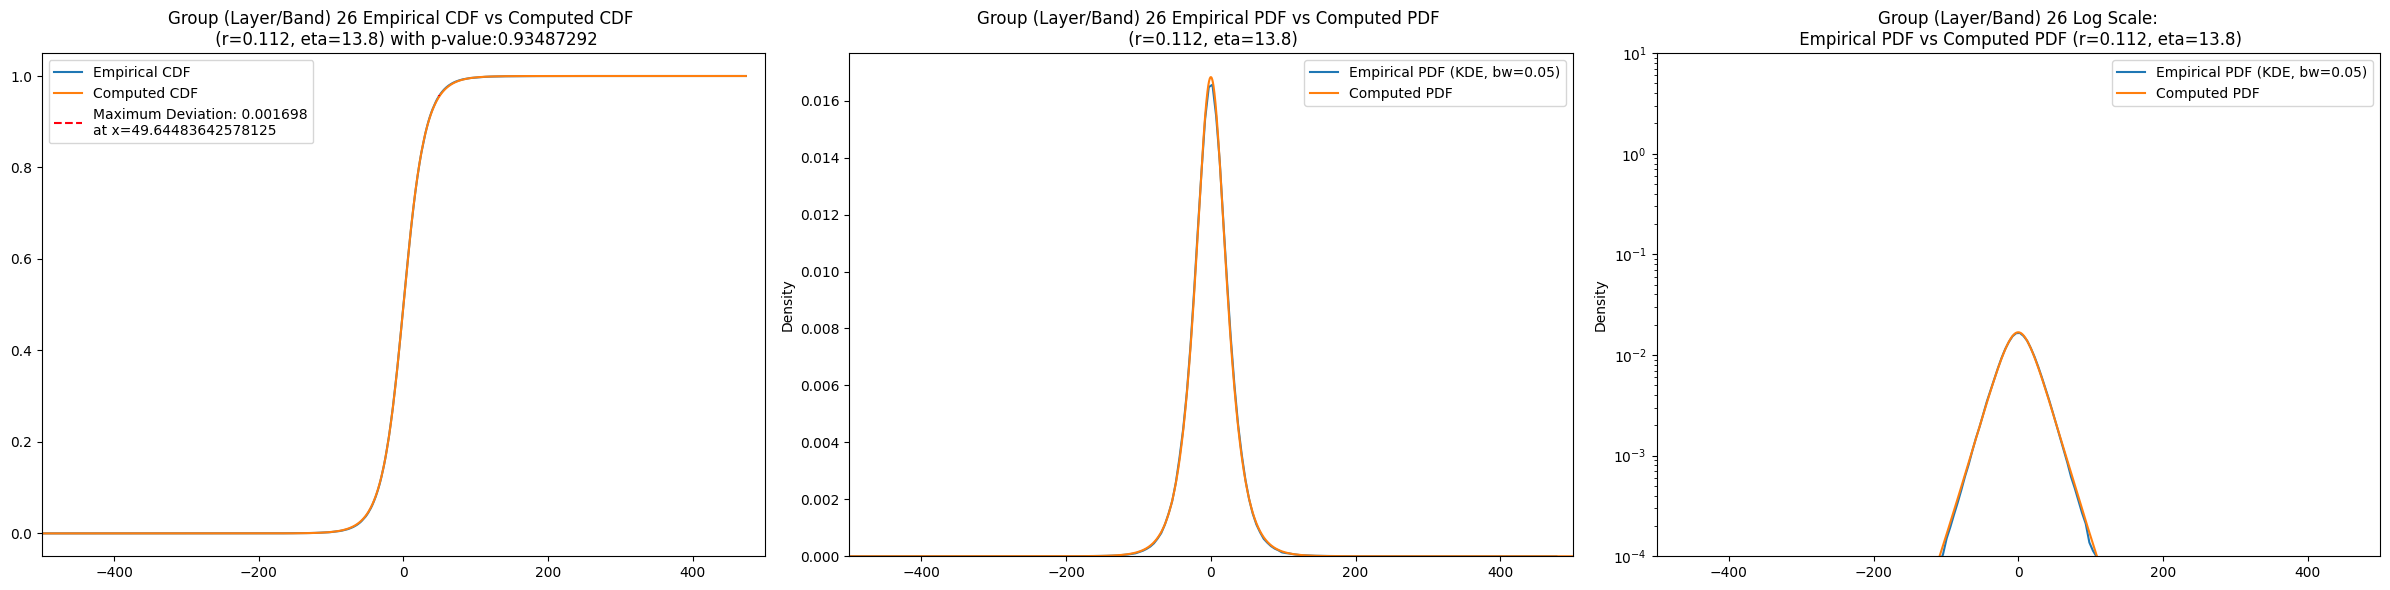

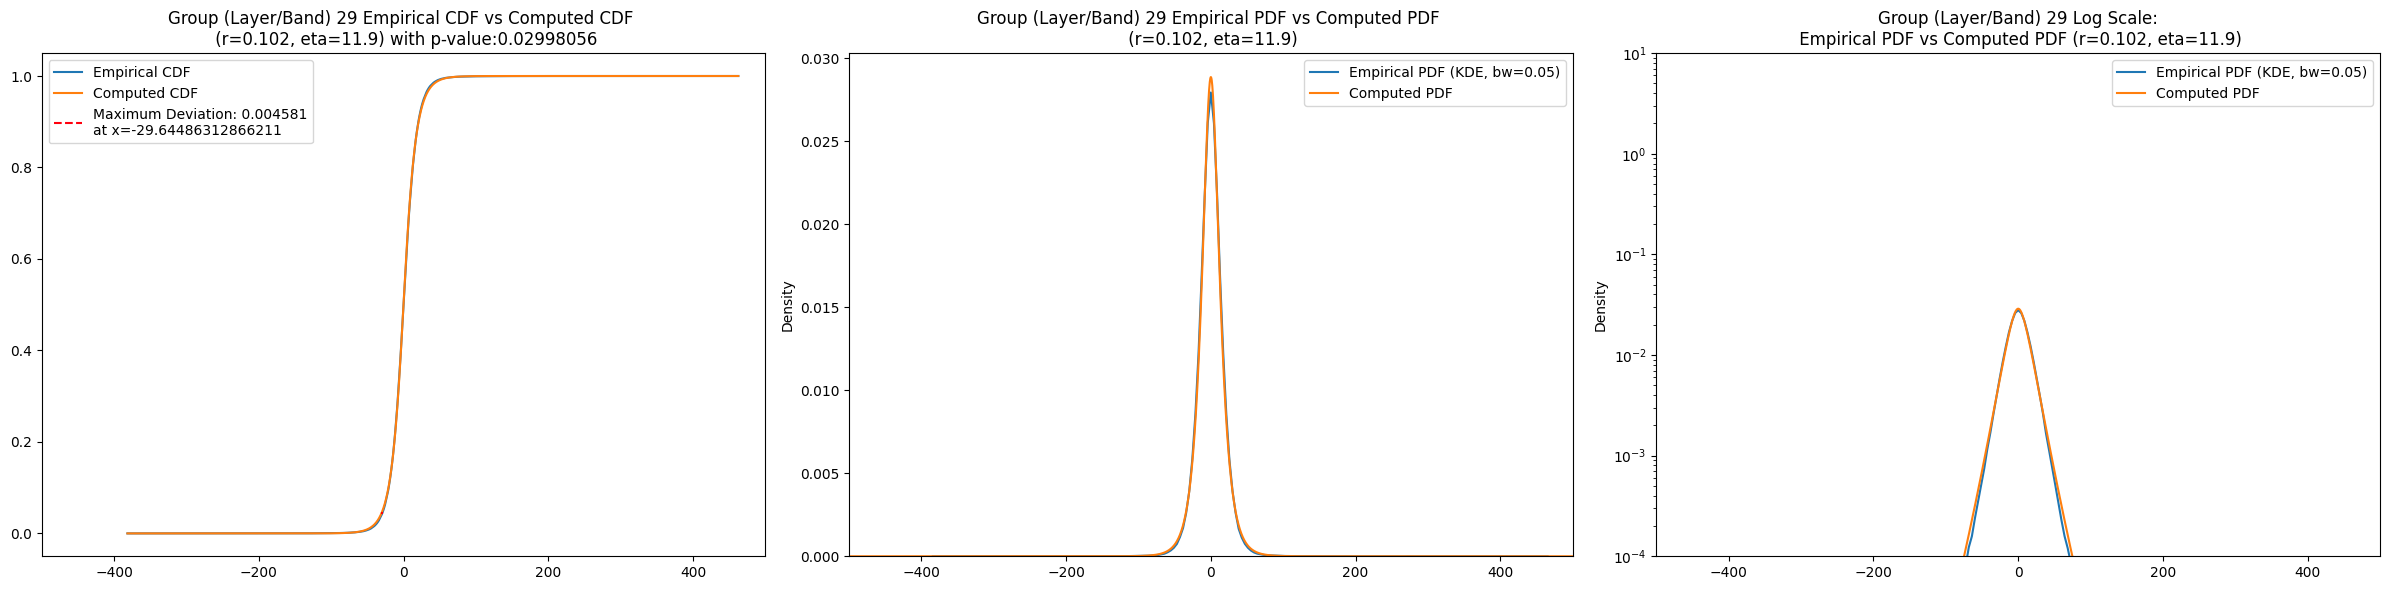

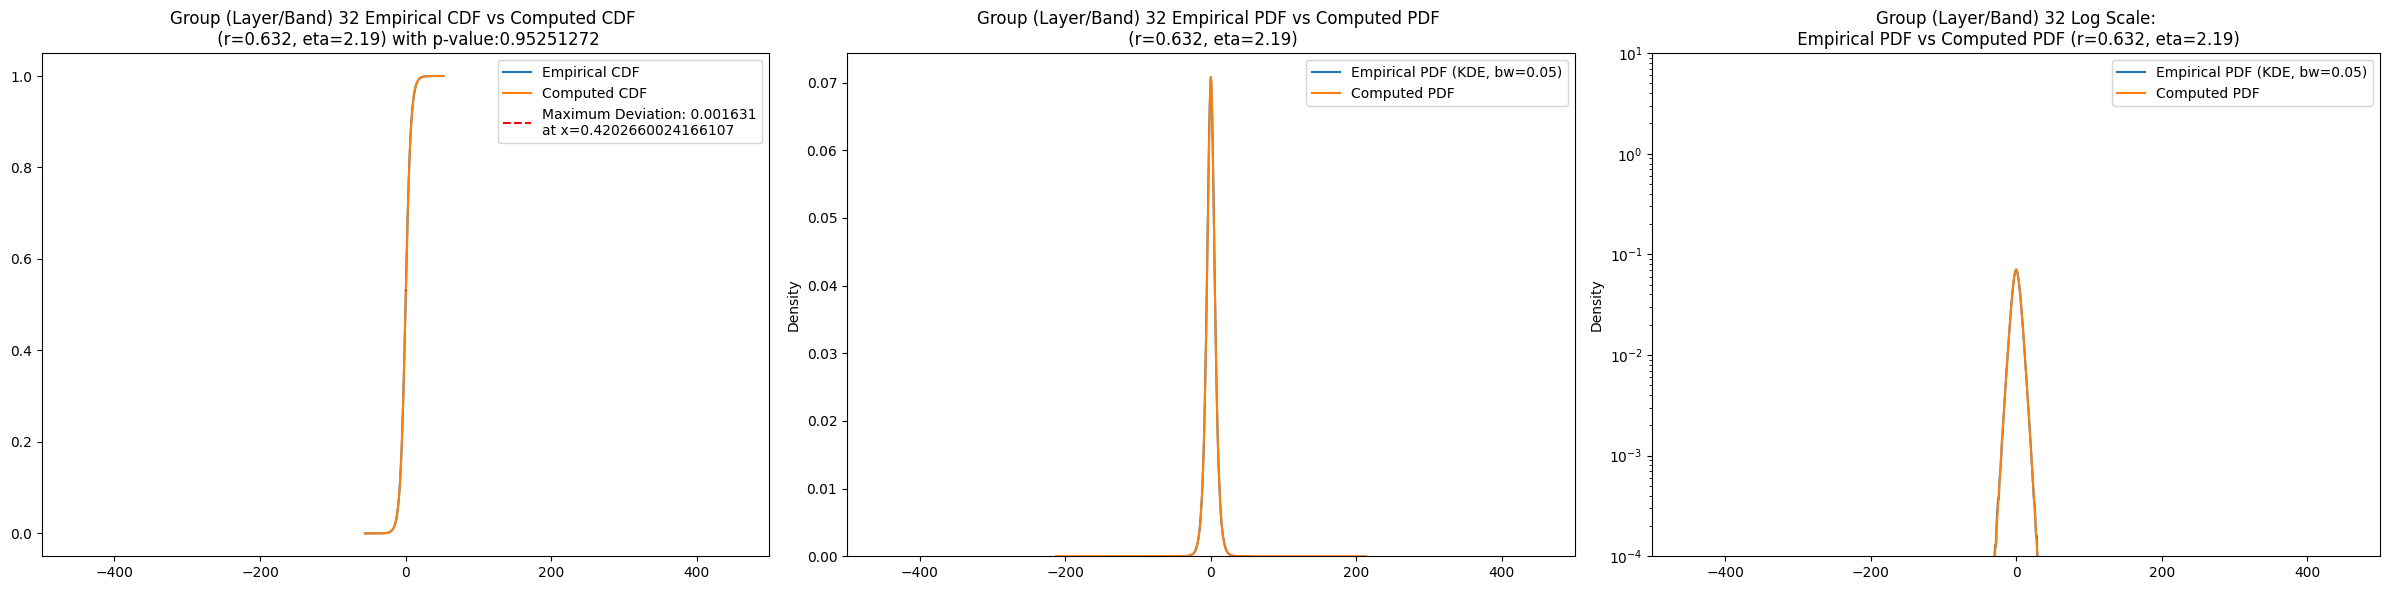

In [18]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    interval = (-500, 500),
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [19]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample / np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
band                                                                       
2     157269.880000  149264.110000  165654.390000   2.019593    1.471349   
5      83422.350000   79257.164000   87787.930000   1.903983    1.275784   
8      45610.926000   43328.332000   47969.348000   1.937604    1.312301   
11     25793.922000   24441.889000   27232.033000   2.370253    1.365877   
14     14051.502000   13346.595000   14808.067000   2.089291    1.275146   
17      7919.142600    7515.967300    8348.544000   2.151878    1.293355   
20      4052.697300    3844.855700    4287.259000   2.416864    1.276760   
23      1979.636500    1878.425500    2088.579000   2.248149    1.370794   
26       868.004900     815.872400     934.296900   4.653831    1.694718   
29       329.394470     302.999200     371.574920  13.155254    2.838861   
32        44.476166      42.376705      46.640842   1.459712    1.005672   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                                    ...   
2       2.704436        31800.0       0.54          1.8   4.881908e+03  ...   
5       2.832162        41340.0       0.19          8.9   4.851825e-05  ...   
8       2.837549        66780.0       0.16         11.0   5.496529e-08  ...   
11      4.514517       104940.0       0.18          9.7   2.286282e-06  ...   
14      4.009901       162180.0       0.35          4.6   3.451052e+00  ...   
17      4.513294       257580.0       0.17         10.0   1.103242e-07  ...   
20      9.097979       381600.0       0.27          5.7   1.769795e-02  ...   
23      4.596758       610560.0       0.19          8.7   1.270410e-06  ...   
26     18.998148       973080.0       0.12         13.0   3.016086e-15  ...   
29     66.098460      1376940.0       0.11         11.0   4.943743e-17  ...   
32      2.262223       419760.0       0.63          2.2   2.484432e+00  ...   

      kstest_stat_gaussian  kstest_pval_gaussian  param_laplace  \
band                                                              
2                 0.015910          2.016780e-07      313.80700   
5                 0.013652          4.019870e-07      231.52500   
8                 0.014275          2.993590e-12      171.98200   
11                0.013043          6.167150e-16      128.66300   
14                0.012871          9.126700e-24       95.83000   
17                0.013616          6.547370e-42       71.27260   
20                0.013376          9.778240e-60       50.86490   
23                0.013205          6.623610e-93       35.52790   
26                0.013473         7.219540e-154       23.20090   
29                0.013391         6.903890e-215       13.84850   
32                0.011813          2.614490e-51        5.42934   

      kstest_stat_laplace  kstest_pval_laplace    param_t  kstest_stat_t  \
band                                                                       
2                0.016523         5.689850e-08  255.19500       0.019143   
5                0.017871         6.710060e-12  186.68700       0.020131   
8                0.018332         6.337100e-20  138.16400       0.020292   
11               0.017897         1.253170e-29  103.63500       0.020098   
14               0.018921         7.241350e-51   77.09990       0.020455   
17               0.016884         3.237550e-64   57.18100       0.019349   
20               0.016803         5.138370e-94   41.02590       0.019457   
23               0.016825        1.427920e-150   28.68190       0.019406   
26               0.016557        3.894990e-232   18.68740       0.018817   
29               0.016349                  NaN   11.19050       0.018653   
32               0.018469        8.269800e-125    4.37047       0.020807   

      kstest_pval_t  kstest_pval_gengamma  pass_all  
band                                                 
2      1.488480e-10       

## Results

In [25]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [26]:
master_df

obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
band                                                                       
2     157269.880000  149264.110000  165654.390000   2.019593    1.471349   
5      83422.350000   79257.164000   87787.930000   1.903983    1.275784   
8      45610.926000   43328.332000   47969.348000   1.937604    1.312301   
11     25793.922000   24441.889000   27232.033000   2.370253    1.365877   
14     14051.502000   13346.595000   14808.067000   2.089291    1.275146   
17      7919.142600    7515.967300    8348.544000   2.151878    1.293355   
20      4052.697300    3844.855700    4287.259000   2.416864    1.276760   
23      1979.636500    1878.425500    2088.579000   2.248149    1.370794   
26       868.004900     815.872400     934.296900   4.653831    1.694718   
29       329.394470     302.999200     371.574920  13.155254    2.838861   
32        44.476166      42.376705      46.640842   1.459712    1.005672   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                                    ...   
2       2.704436        31800.0       0.54          1.8   4.881908e+03  ...   
5       2.832162        41340.0       0.19          8.9   4.851825e-05  ...   
8       2.837549        66780.0       0.16         11.0   5.496529e-08  ...   
11      4.514517       104940.0       0.18          9.7   2.286282e-06  ...   
14      4.009901       162180.0       0.35          4.6   3.451052e+00  ...   
17      4.513294       257580.0       0.17         10.0   1.103242e-07  ...   
20      9.097979       381600.0       0.27          5.7   1.769795e-02  ...   
23      4.596758       610560.0       0.19          8.7   1.270410e-06  ...   
26     18.998148       973080.0       0.12         13.0   3.016086e-15  ...   
29     66.098460      1376940.0       0.11         11.0   4.943743e-17  ...   
32      2.262223       419760.0       0.63          2.2   2.484432e+00  ...   

      kstest_stat_gaussian  kstest_pval_gaussian  param_laplace  \
band                                                              
2                 0.015910          2.016780e-07      313.80700   
5                 0.013652          4.019870e-07      231.52500   
8                 0.014275          2.993590e-12      171.98200   
11                0.013043          6.167150e-16      128.66300   
14                0.012871          9.126700e-24       95.83000   
17                0.013616          6.547370e-42       71.27260   
20                0.013376          9.778240e-60       50.86490   
23                0.013205          6.623610e-93       35.52790   
26                0.013473         7.219540e-154       23.20090   
29                0.013391         6.903890e-215       13.84850   
32                0.011813          2.614490e-51        5.42934   

      kstest_stat_laplace  kstest_pval_laplace    param_t  kstest_stat_t  \
band                                                                       
2                0.016523         5.689850e-08  255.19500       0.019143   
5                0.017871         6.710060e-12  186.68700       0.020131   
8                0.018332         6.337100e-20  138.16400       0.020292   
11               0.017897         1.253170e-29  103.63500       0.020098   
14               0.018921         7.241350e-51   77.09990       0.020455   
17               0.016884         3.237550e-64   57.18100       0.019349   
20               0.016803         5.138370e-94   41.02590       0.019457   
23               0.016825        1.427920e-150   28.68190       0.019406   
26               0.016557        3.894990e-232   18.68740       0.018817   
29               0.016349                  NaN   11.19050       0.018653   
32               0.018469        8.269800e-125    4.37047       0.020807   

      kstest_pval_t  kstest_pval_gengamma  pass_all  
band                                                 
2      1.488480e-10       

In [ ]:
remove_directory(os.path.join(CWD, "groupCDFs"))